# Lead Scoring Case Study 

- Supervised Learning Algorithm - Logistic Regression [ Classification ]
- Programming Language - Python
- Developed by UV, VK, VY


## Initialization - Preprocessing - Visualization

### 1. Package Imports and Data Initialization

In [1325]:
# import all libraries numpy, pandas, matplotlib, seaborn. 
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mplib
import seaborn as sns; sns.set_theme(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

# Set custom display properties in pandas
pd.set_option("display.max_rows", 900)
pd.set_option("display.max_columns", 900) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [1326]:
# Import the necessary machine learning packages (sklearn, statsmodel) for performing logistic regression
import statsmodels.api as sm 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, recall_score,precision_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, precision_recall_curve

In [1327]:
# Import the dataset from leads.csv
lead_score_df = pd.read_csv('Leads.csv')
lead_score_df.head(1)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.000,0,0.000,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.000,15.000,No,No,Modified


###  ----------------------------------------------------------------------

### 2. Data Preprocesing - Part 1

#### Custom Functions for Preprocessing and EDA

In [1328]:
# To distinguish numerical columns either as categorical/discrete or non categorical and return as dict
def classify_feature_dtype(df, cols):
    d_categories = {'int_cat': [], "float_ts":[] }
    for col in cols:
        if (len(df[col].unique()) < 20):
            d_categories['int_cat'].append(col)
        else:
            if not isinstance(df[col][df[col].notna()].unique()[0], str):
                d_categories['float_ts'].append(col)
            else:
                d_categories['int_cat'].append(col)
    return d_categories

# Print all statistical information for a given set of columns
def show_stats(df, cols):
    for col in list(cols):
        print("Total Nulls: {0},\nMode: {1}".format(df[col].isna().sum(), df[col].mode()[0]))
        if len(df[col].unique()) < 50:
            print("\nUnique: {0}\n".format(df[col].unique()))
        if (df[col].dtype == int) or (df[col].dtype == float):
            print("Median   : {0}, \nVariance: {1}, \n\nDescribe: {2} \n".format(df[col].median(), df[col].var(), df[col].describe()))
        print("ValueCounts: {0} \n\n\n".format((df[col].value_counts(normalize=True) * 100).head(5)))
        print("------------------------------------------------------------------")

# Return the percentage of null values in each columns in a dataframe
def check_cols_null_pct(df):
    df_non_na = df.count() / len(df)  # Ratio of non null values
    df_na_pct = (1 - df_non_na) * 100 # Find the Percentage of null values
    return df_na_pct.sort_values(ascending=False) # Sort the resulting values in descending order

# Generates charts based on the data type of the cols, as part of the univariate analysis 
# it takes dataframe, columns, train data 0,1, and feature type as args.
def univariate_plots(df, cols, target=None, ftype=None, l_dict = None):
    for col in cols:
        #generate plots and graphs for category type. (generates piechart, countplot, boxplot / if training data is provided it generates bar chart instead)
        if ftype == "categorical":
            fig, axs = plt.subplots(1, 3, figsize=(20, 6))
 
            col_idx = 0
            axs[col_idx].pie(x=df[col].value_counts().head(12), labels=df[col].value_counts().head(12).index.str[:10], autopct="%1.1f%%", 
                    radius=1, textprops={"fontsize": 10, "color": "Black"}, startangle=90, rotatelabels=False, )
            axs[col_idx].set_title("PieChart of {0}".format(col), y=1); plt.xticks(rotation=45); plt.ylabel("Percentage")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1
            sns.countplot(data=df, y=col, order=df[col].value_counts().head(15).index, palette="viridis",  ax=axs[col_idx])
            if (l_dict is not None) and (l_dict.get(col) is not None):
                axs[col_idx].legend([ f'{k} - {v}' for k,v in l_dict[col].items()])
            axs[col_idx].set_title("Countplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col); plt.ylabel("Count")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            col_idx += 1
            ax = sns.barplot(data=df, x=df[col].str[:10], y=target, order=df[col].value_counts().index.str[:10], palette="viridis",  ax=axs[col_idx], errwidth=0)
            for i in ax.containers:
                ax.bar_label(i,)
            axs[col_idx].set_title('Barplot against target'); plt.xticks(rotation=90); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show();
            plt.clf()

        #generate plots and graphs for numerical types. (generates boxplot, histplot, kdeplot, scatterplot)
        elif ftype == "non_categorical":        
            fig, axs = plt.subplots(1, 4, figsize=(20, 6))
            
            col_idx = 0
            
            sns.boxplot(data=df, y=col, palette="viridis", flierprops=dict(marker="o", markersize=6, markerfacecolor="red", markeredgecolor="black"),
                        medianprops=dict(linestyle="-", linewidth=3, color="#FF9900"), whiskerprops=dict(linestyle="-", linewidth=2, color="black"),
                        capprops=dict(linestyle="-", linewidth=2, color="black"), ax=axs[col_idx])
            axs[col_idx].set_title("Boxplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            axs[col_idx].hist(data=df, x=col, label=col)
            axs[col_idx].set_title("Histogram of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.kdeplot(df[col], shade=True, ax=axs[col_idx])
            axs[col_idx].set_title("KDE plot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.scatterplot(df[col], ax=axs[col_idx])
            axs[col_idx].set_title("Scatterplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()
            plt.clf()

# Perform Outlier analysis on the given dataframe.
# Find Lower threshold, Upper threshold and IQR values. 
# Return the Result as a dataframe. 
# find_outlier = True argument: restricts the output df to outlier columns. whereas find_outlier = False: returns results for all columns
def get_extremeval_threshld(df, find_outlier=False):
    outlier_df = pd.DataFrame(columns=[i for i in df.columns if find_outlier == True], data=None)
    
    for col in df.columns:
        thirdq, firstq = df[col].quantile(0.75), df[col].quantile(0.25)
        iqr = 1.5 * (thirdq - firstq)
        extvalhigh, extvallow = iqr + thirdq, firstq - iqr
        
        if find_outlier == True:
            dfout = df.loc[(df[col] > extvalhigh) | (df[col] < extvallow)]
            dfout = dfout.assign(name=col, thresh_low=extvallow, thresh_high=extvalhigh)
        else:
            dfout = pd.DataFrame([[col, extvallow, extvalhigh]], columns=['name', 'thresh_low', 'thresh_high'])
            
        outlier_df = pd.concat([outlier_df, dfout])
    # outlier_df = outlier_df.reset_index(drop=True)
    outlier_df = outlier_df.set_index('name',drop=True)
    return outlier_df

#### Data Cleaning, Column Renaming, Missing Value Imputation, Feature Selection

In [1329]:
#duplicates row validation by id cols
print(f"{lead_score_df.index.is_unique}, {lead_score_df.columns.is_unique}, {lead_score_df['Prospect ID'].is_unique}, {lead_score_df['Lead Number'].is_unique}")

True, True, True, True


In [1330]:
# drop unnecessary columns
lead_score_df = lead_score_df.drop(columns=['Prospect ID','Lead Number', 'I agree to pay the amount through cheque', 'Last Notable Activity'])

In [1331]:
# rename columns that are too long
lead_score_df = lead_score_df.rename(columns={'Total Time Spent on Website':'ttime_on_site', 'Page Views Per Visit':'pg_view_pv', 'How did you hear about X Education':'info_abt_X_Edu', 'What is your current occupation':'curr_occupation',
    'What matters most to you in choosing a course':'reason_behind_course', 'Receive More Updates About Our Courses':'more_course_updates', 'Update me on Supply Chain Content':'supply_chain_info', 'Get updates on DM Content':'get_dm',
    'Asymmetrique Activity Index':'asym_activ_idx', 'Asymmetrique Profile Index':'asym_prof_idx', 'Asymmetrique Activity Score':'asym_activ_score', 'Asymmetrique Profile Score':'asym_prof_score',
    'A free copy of Mastering The Interview':'avail_free_copy'})

In [1332]:
# replace unnecessary space in columns with underscore and covert it to lower case
lead_score_df.columns = lead_score_df.columns.str.replace(pat=' ',repl='_', regex=True)
lead_score_df.columns = lead_score_df.columns.str.lower()

In [1333]:
# Check the shape and size of the data frame
lead_score_df.head(1)
lead_score_df.dtypes
print(f'{lead_score_df.shape}, {lead_score_df.size}')

,lead_origin,lead_source,do_not_email,do_not_call,converted,totalvisits,ttime_on_site,pg_view_pv,last_activity,country,specialization,info_abt_x_edu,curr_occupation,reason_behind_course,search,magazine,newspaper_article,x_education_forums,newspaper,digital_advertisement,through_recommendations,more_course_updates,tags,lead_quality,supply_chain_info,get_dm,lead_profile,city,asym_activ_idx,asym_prof_idx,asym_activ_score,asym_prof_score,avail_free_copy
0,API,Olark Chat,No,No,0,0.000,0,0.000,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.000,15.000,No


lead_origin                 object
lead_source                 object
do_not_email                object
do_not_call                 object
converted                    int64
totalvisits                float64
ttime_on_site                int64
pg_view_pv                 float64
last_activity               object
country                     object
specialization              object
info_abt_x_edu              object
curr_occupation             object
reason_behind_course        object
search                      object
magazine                    object
newspaper_article           object
x_education_forums          object
newspaper                   object
digital_advertisement       object
through_recommendations     object
more_course_updates         object
tags                        object
lead_quality                object
supply_chain_info           object
get_dm                      object
lead_profile                object
city                        object
asym_activ_idx      

(9240, 33), 304920


In [1334]:
# check null val percentage
# After checking the null value percentage for all the features
# We could see that there are many features that have more than 45% of non values

check_cols_null_pct(lead_score_df)

lead_quality              51.591
asym_prof_score           45.649
asym_activ_score          45.649
asym_prof_idx             45.649
asym_activ_idx            45.649
tags                      36.288
lead_profile              29.318
reason_behind_course      29.318
curr_occupation           29.113
country                   26.634
info_abt_x_edu            23.885
specialization            15.563
city                      15.368
pg_view_pv                 1.483
totalvisits                1.483
last_activity              1.115
lead_source                0.390
more_course_updates        0.000
get_dm                     0.000
supply_chain_info          0.000
lead_origin                0.000
newspaper_article          0.000
through_recommendations    0.000
digital_advertisement      0.000
newspaper                  0.000
x_education_forums         0.000
magazine                   0.000
search                     0.000
ttime_on_site              0.000
converted                  0.000
do_not_cal

In [1335]:
# replace select string with nan
lead_score_df[['tags','specialization']] = lead_score_df[['tags','specialization']].replace(to_replace=['select','Select',np.nan], value='unknown') ###--------------------->>>>>>>>>>>>>>>
lead_score_df = lead_score_df.replace(to_replace=['select','Select'], value=np.nan) 

# validate select str is replaced
[i for i in lead_score_df.columns if 'select' in (lead_score_df[i].astype(str).str.lower()).str.findall('select').value_counts().index.map(''.join).to_list()]

[]

##### Constant Feature Identification

In [1336]:
# check constant features that has only one values
# In the given data set there are a lot of features that have only single value as a category
# These are called as constant features and these features are of little relevance for the machine learning model hence we dropped those features
 
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_constant_features

constant_features = get_constant_features(lead_score_df)
constant_features.head(10)
"','".join(constant_features['Var'].to_list())

,Desc,Var,Value,Perc
0,Constant,magazine,No,100.000
1,Constant,more_course_updates,No,100.000
2,Constant,supply_chain_info,No,100.000
3,Constant,get_dm,No,100.000
4,Quasi Constant,x_education_forums,No,99.989
5,Quasi Constant,newspaper,No,99.989
6,Quasi Constant,do_not_call,No,99.978
7,Quasi Constant,newspaper_article,No,99.978
8,Quasi Constant,digital_advertisement,No,99.957
9,Quasi Constant,through_recommendations,No,99.924


"magazine','more_course_updates','supply_chain_info','get_dm','x_education_forums','newspaper','do_not_call','newspaper_article','digital_advertisement','through_recommendations','search"

#####

In [1337]:
# drop all the constant_features
lead_score_df = lead_score_df.drop(['magazine', 'more_course_updates', 'supply_chain_info', 'get_dm', 'x_education_forums', 
                                    'newspaper', 'do_not_call', 'newspaper_article', 'digital_advertisement', 'through_recommendations', 'search'], axis=1)

In [1338]:
# convert dtypes
# Convert the data type of certain features from object to category type

obj_cols = lead_score_df.select_dtypes(include='object').columns
lead_score_df[obj_cols] = lead_score_df[obj_cols].astype(dtype='category')

In [1339]:
# check null val percentage
# Since we have replaced select as null value for certain columns we are seeing increase in the null value percentage for those features
# Therefore we dropped all the features that have more than 40 of null values

null_pct = check_cols_null_pct(lead_score_df)
null_pct
lead_score_df = lead_score_df.drop(null_pct[null_pct > 40].index, axis=1)

info_abt_x_edu         78.463
lead_profile           74.188
lead_quality           51.591
asym_prof_score        45.649
asym_activ_score       45.649
asym_prof_idx          45.649
asym_activ_idx         45.649
city                   39.708
reason_behind_course   29.318
curr_occupation        29.113
country                26.634
totalvisits             1.483
pg_view_pv              1.483
last_activity           1.115
lead_source             0.390
lead_origin             0.000
tags                    0.000
specialization          0.000
ttime_on_site           0.000
converted               0.000
do_not_email            0.000
avail_free_copy         0.000
dtype: float64

In [1340]:
null_pct = check_cols_null_pct(lead_score_df)
null_pct
na_cols = null_pct[null_pct > 0].index
na_cols

city                   39.708
reason_behind_course   29.318
curr_occupation        29.113
country                26.634
totalvisits             1.483
pg_view_pv              1.483
last_activity           1.115
lead_source             0.390
lead_origin             0.000
do_not_email            0.000
converted               0.000
ttime_on_site           0.000
specialization          0.000
tags                    0.000
avail_free_copy         0.000
dtype: float64

Index(['city', 'reason_behind_course', 'curr_occupation', 'country',
       'totalvisits', 'pg_view_pv', 'last_activity', 'lead_source'],
      dtype='object')

In [1341]:
lead_score_df.describe(include=np.number)
lead_score_df.describe(exclude=np.number)

,converted,totalvisits,ttime_on_site,pg_view_pv
count,9240.000,9103.000,9240.000,9103.000
mean,0.385,3.445,487.698,2.363
std,0.487,4.855,548.021,2.161
min,0.000,0.000,0.000,0.000
25%,0.000,1.000,12.000,1.000
50%,0.000,3.000,248.000,2.000
75%,1.000,5.000,936.000,3.000
max,1.000,251.000,2272.000,55.000


,lead_origin,lead_source,do_not_email,last_activity,country,specialization,curr_occupation,reason_behind_course,tags,city,avail_free_copy
count,9240,9204,9240,9137,6779,9240,6550,6531,9240,5571,9240
unique,5,21,2,17,38,19,6,3,27,6,2
top,Landing Page Submission,Google,No,Email Opened,India,unknown,Unemployed,Better Career Prospects,unknown,Mumbai,No
freq,4886,2868,8506,3437,6492,3380,5600,6528,3353,3222,6352


In [1342]:
# impute missing categorical values using mode, if a particular value in that column has higher frequency say > 50%
for i in lead_score_df.select_dtypes(include='category'):
    temp = lead_score_df[i].value_counts(normalize=True, ascending=False) * 100
    if temp.iloc[0] > 50:
        lead_score_df[i] = lead_score_df[i].fillna(temp.index[0])

In [1343]:
# Now there are only two columns that have more than 36 off missing values tags and specialization

null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]

totalvisits     1.483
pg_view_pv      1.483
last_activity   1.115
lead_source     0.390
dtype: float64

In [1344]:
show_stats(lead_score_df, lead_score_df.columns) ###--------------------->>>>>>>>>>>>>>>

Total Nulls: 0,
Mode: Landing Page Submission

Unique: ['API', 'Landing Page Submission', 'Lead Add Form', 'Lead Import', 'Quick Add Form']
Categories (5, object): ['API', 'Landing Page Submission', 'Lead Add Form', 'Lead Import', 'Quick Add Form']

ValueCounts: lead_origin
Landing Page Submission   52.879
API                       38.745
Lead Add Form              7.771
Lead Import                0.595
Quick Add Form             0.011
Name: proportion, dtype: float64 



------------------------------------------------------------------
Total Nulls: 36,
Mode: Google

Unique: ['Olark Chat', 'Organic Search', 'Direct Traffic', 'Google', 'Referral Sites', ..., 'welearnblog_Home', 'youtubechannel', 'testone', 'Press_Release', 'NC_EDM']
Length: 22
Categories (21, object): ['Click2call', 'Direct Traffic', 'Facebook', 'Google', ..., 'google', 'testone', 'welearnblog_Home', 'youtubechannel']

ValueCounts: lead_source
Google           31.160
Direct Traffic   27.629
Olark Chat       19.068
Orga

In [1345]:
lead_score_df.dtypes

lead_origin             category
lead_source             category
do_not_email            category
converted                  int64
totalvisits              float64
ttime_on_site              int64
pg_view_pv               float64
last_activity           category
country                 category
specialization          category
curr_occupation         category
reason_behind_course    category
tags                    category
city                    category
avail_free_copy         category
dtype: object

###  ----------------------------------------------------------------------

### 3. Data Visualization - EDA

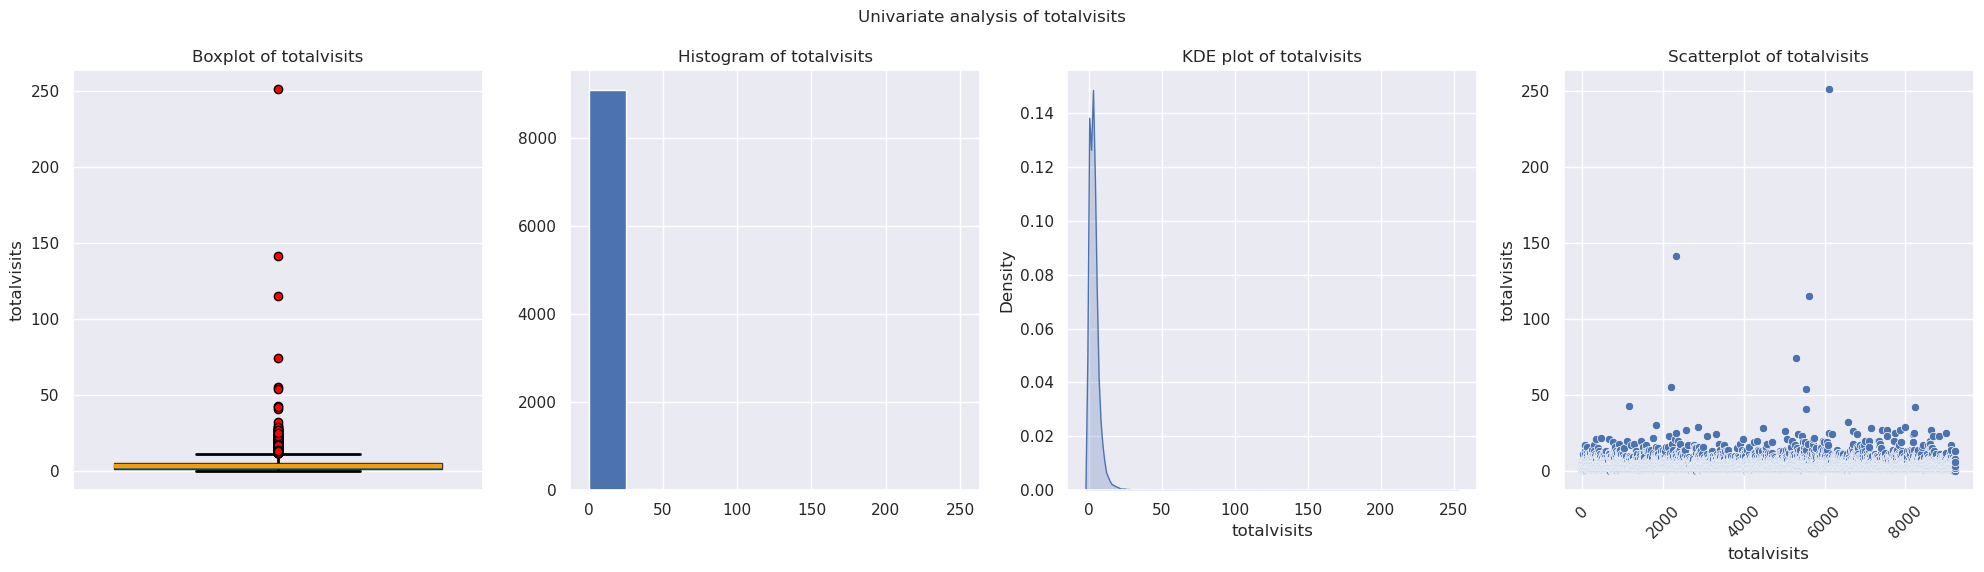

<Figure size 640x480 with 0 Axes>

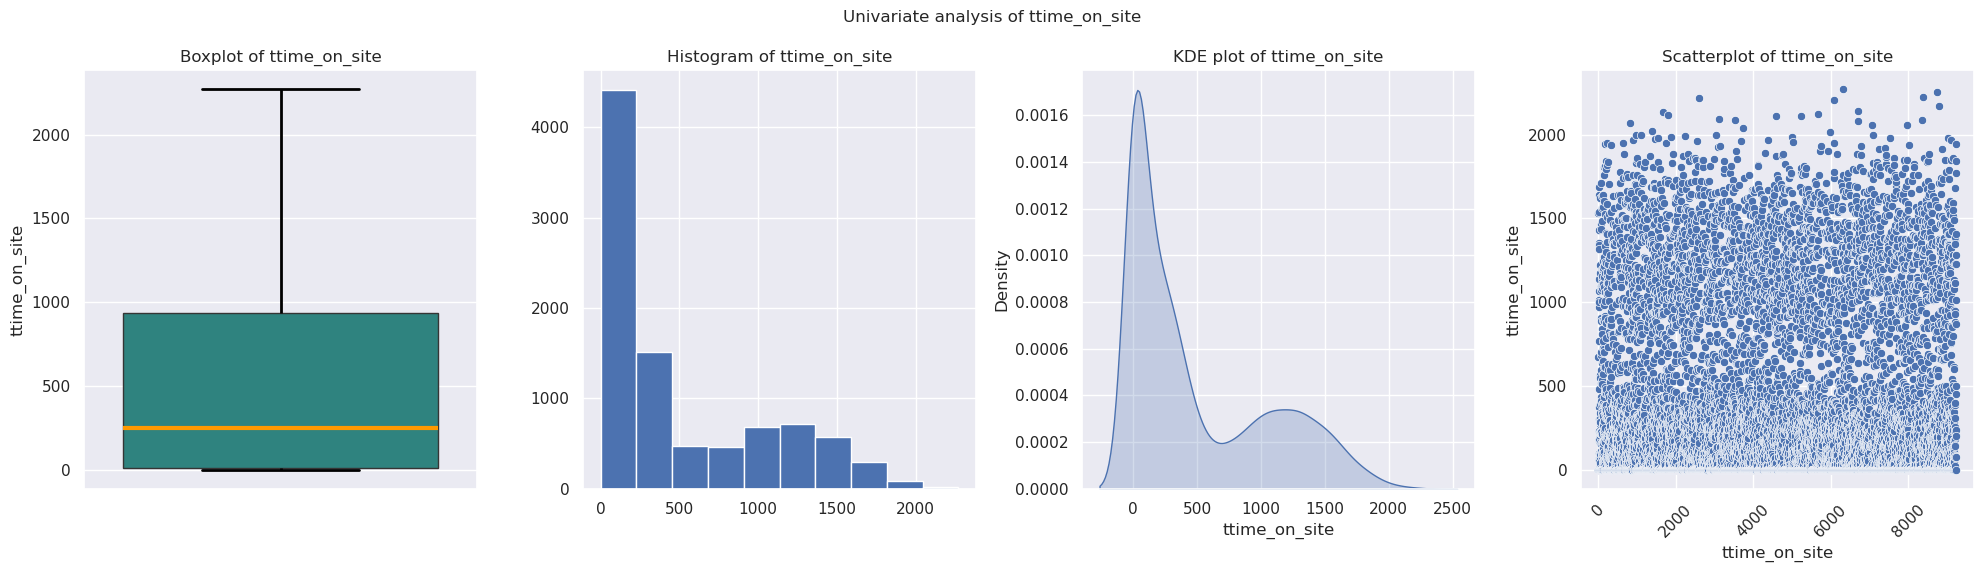

<Figure size 640x480 with 0 Axes>

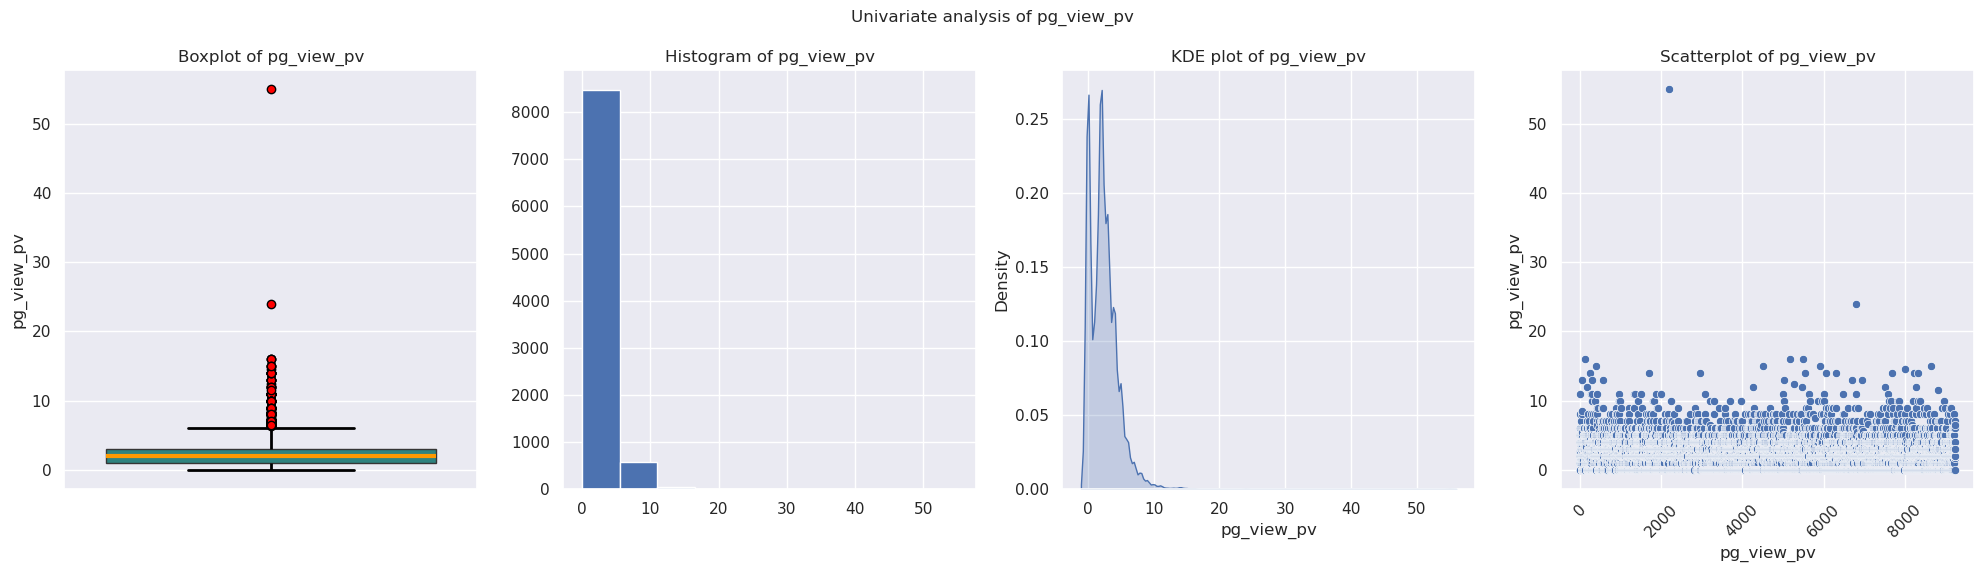

<Figure size 640x480 with 0 Axes>

In [1346]:
# univariate plots#
# Now we perform Univariate analysis on both categorical and numerical variables
dtype_dict = classify_feature_dtype(lead_score_df, lead_score_df.columns )
univariate_plots(lead_score_df, dtype_dict['float_ts'], ftype='non_categorical', target='converted')

#####  Observations

- The converter column has more ones than zeros
- The box plot for total visits shows that there are outliers and the majority of the total visits fall between zero and 30
- The box plot for page view per visit shows that there are outliers majority of them fall between zero and 20

#####

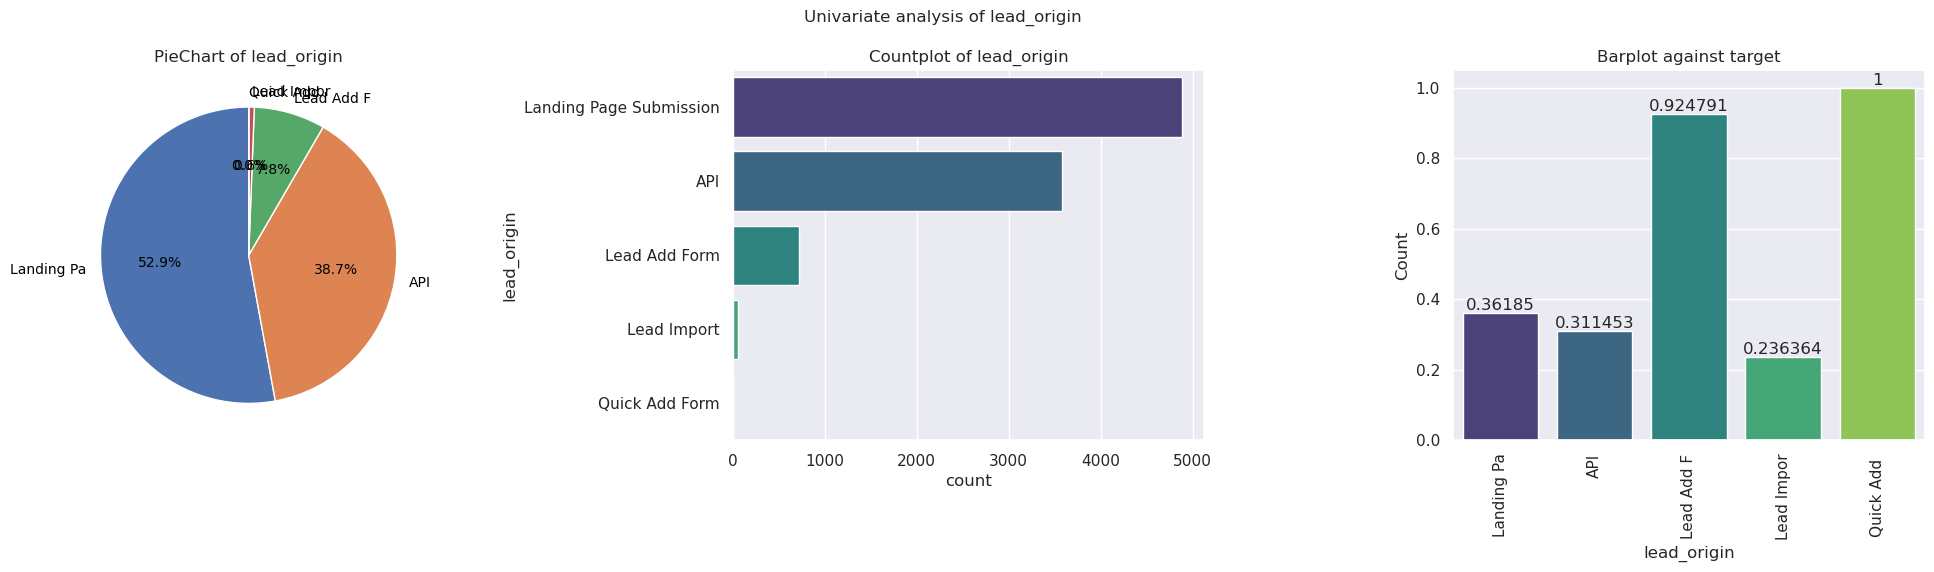

<Figure size 640x480 with 0 Axes>

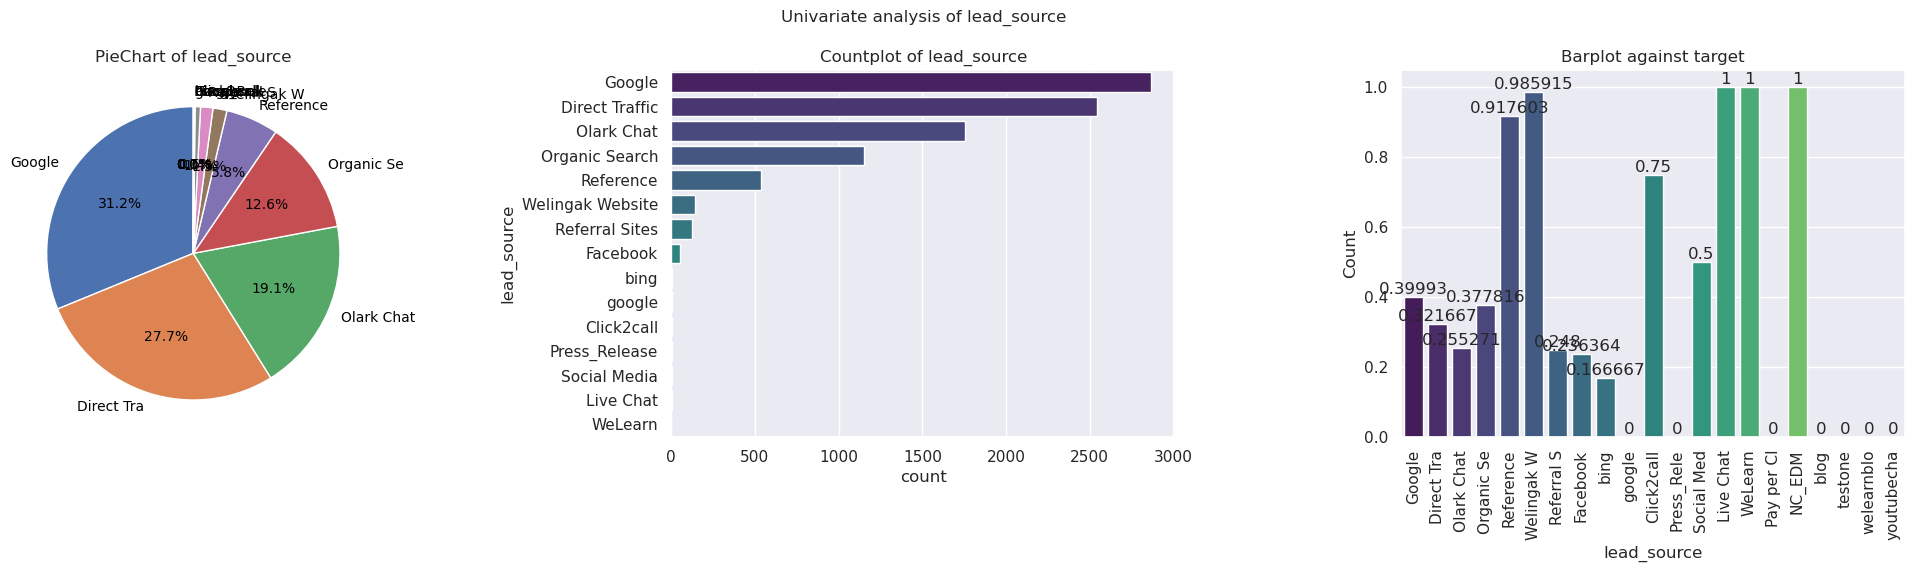

<Figure size 640x480 with 0 Axes>

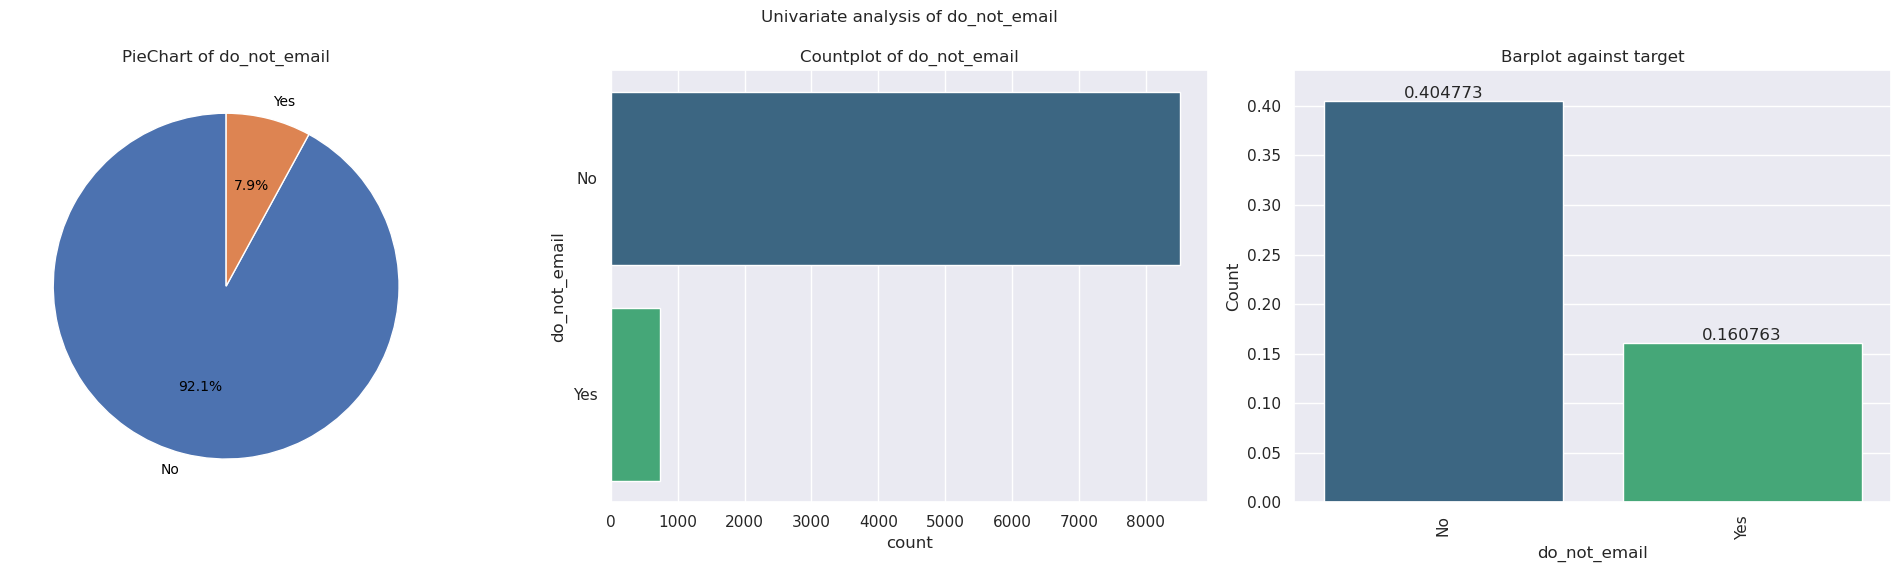

<Figure size 640x480 with 0 Axes>

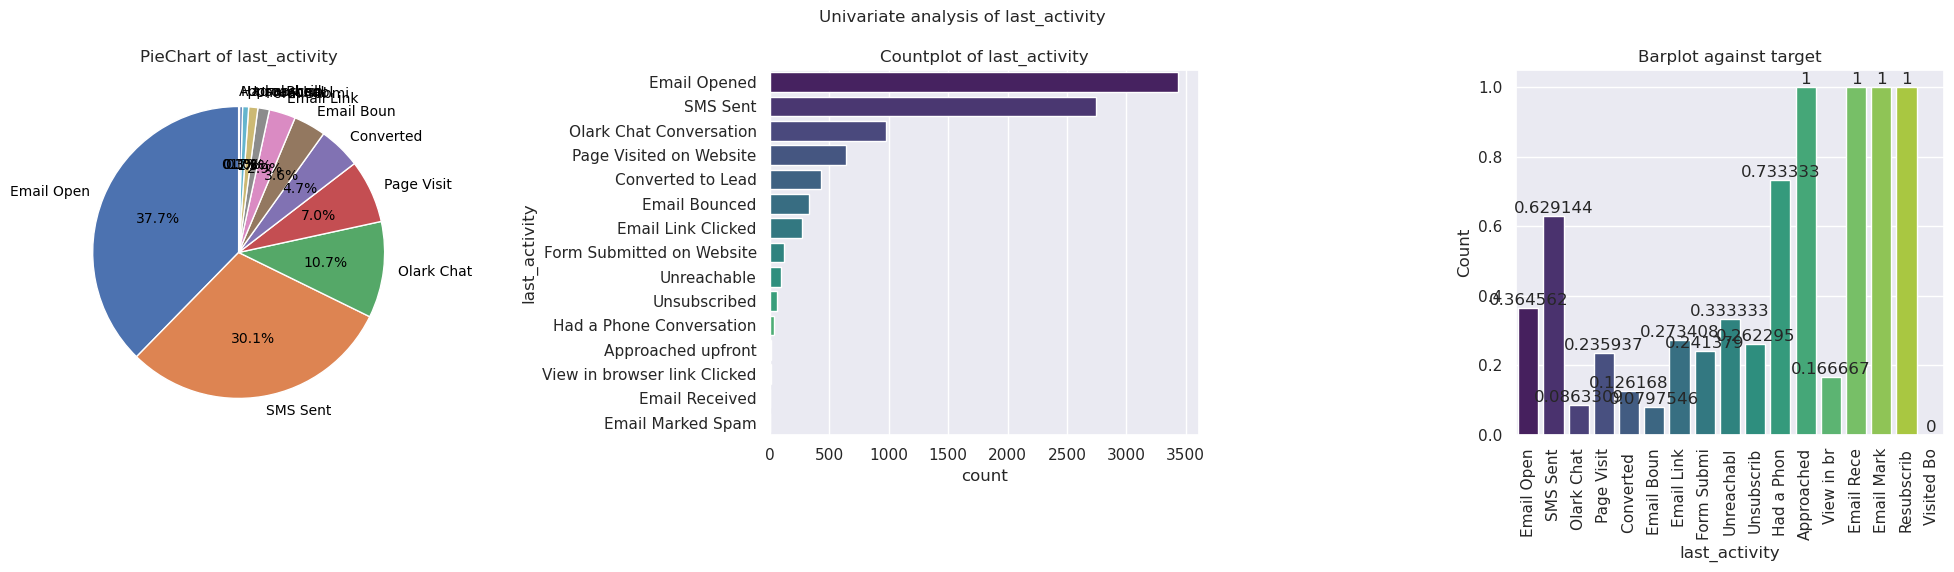

<Figure size 640x480 with 0 Axes>

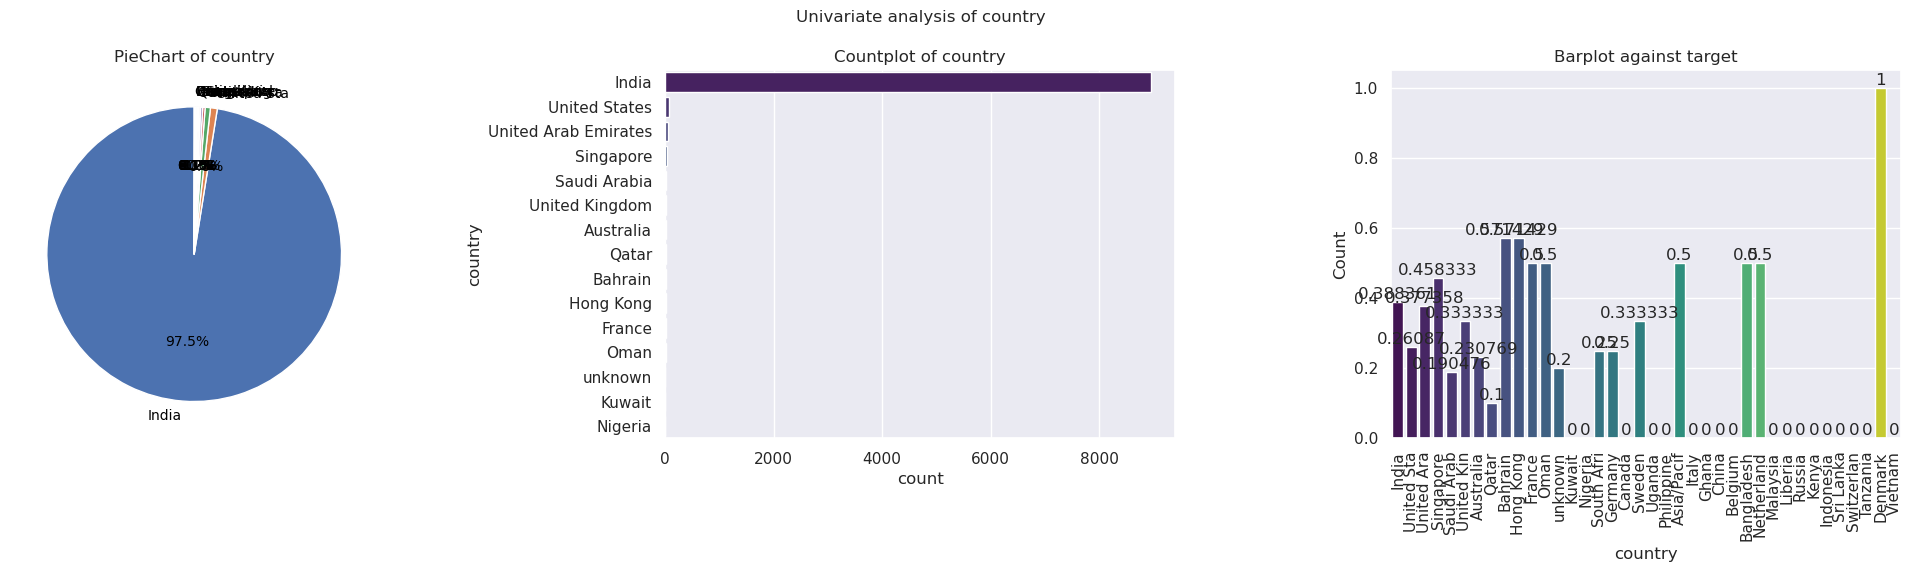

<Figure size 640x480 with 0 Axes>

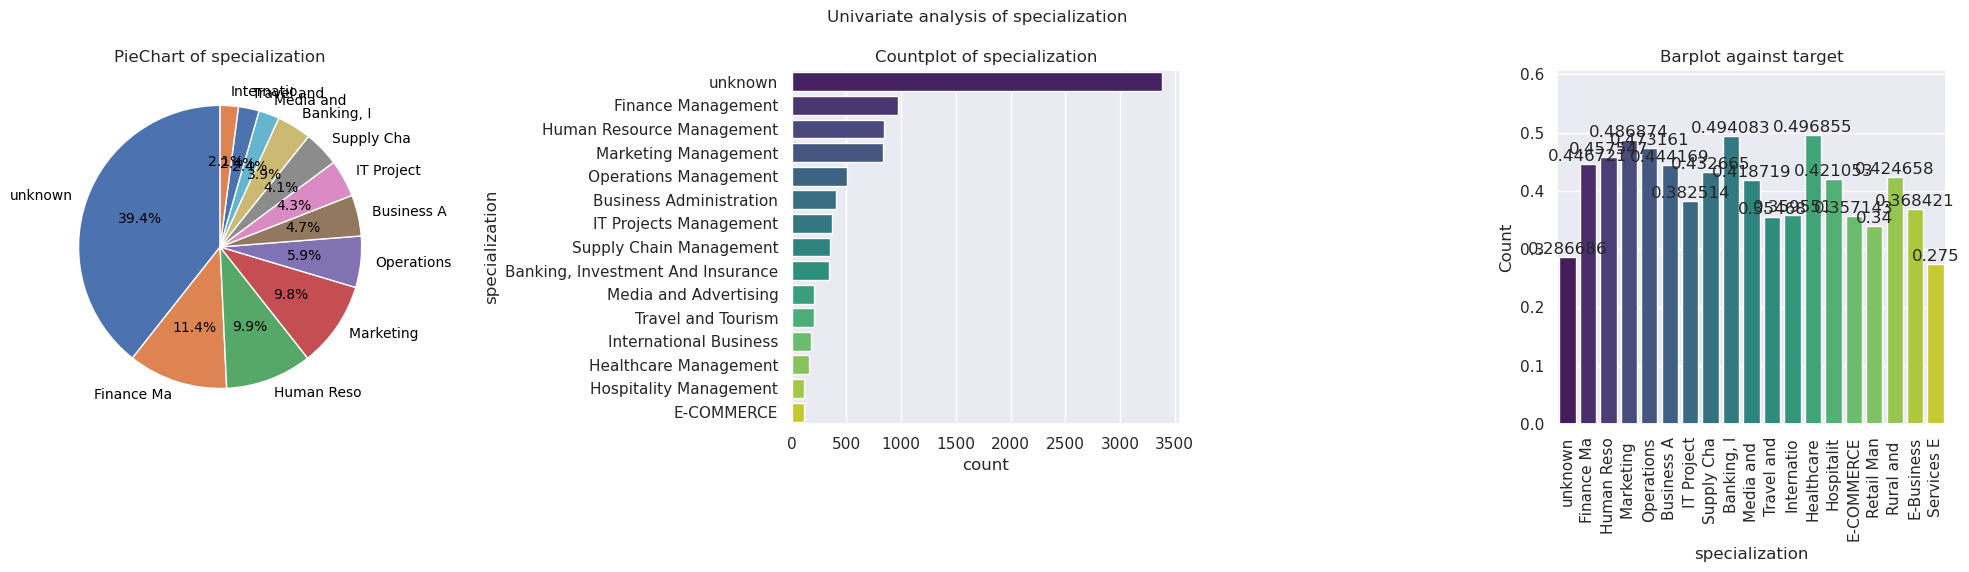

<Figure size 640x480 with 0 Axes>

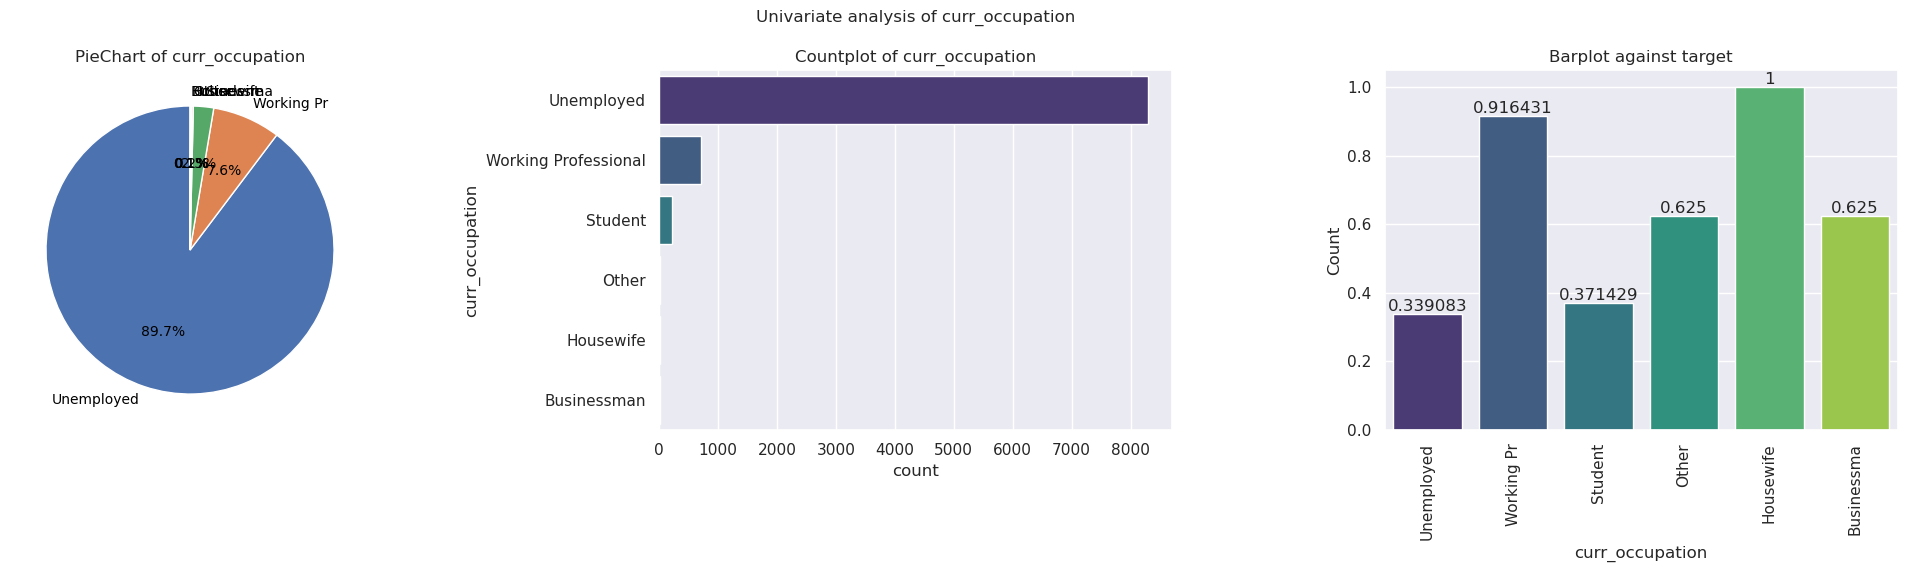

<Figure size 640x480 with 0 Axes>

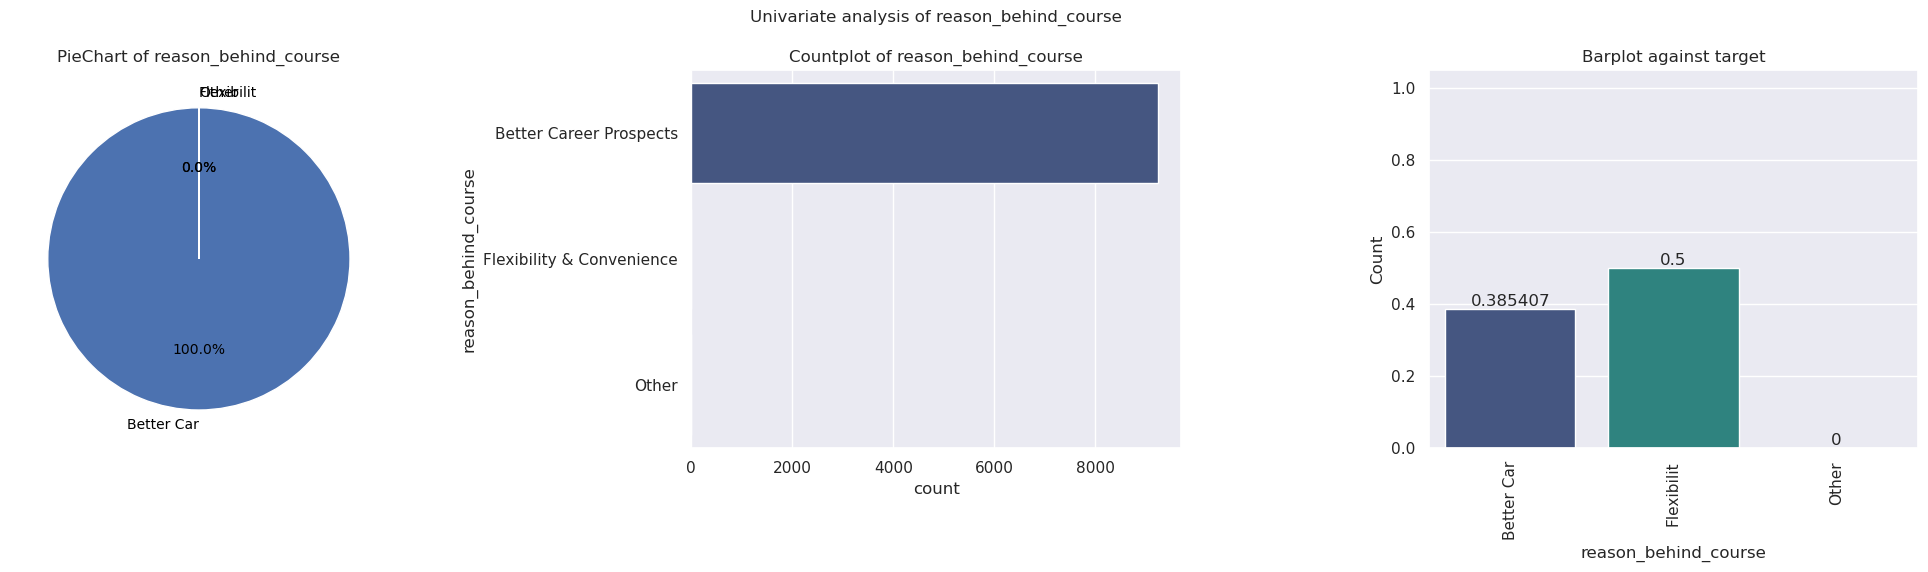

<Figure size 640x480 with 0 Axes>

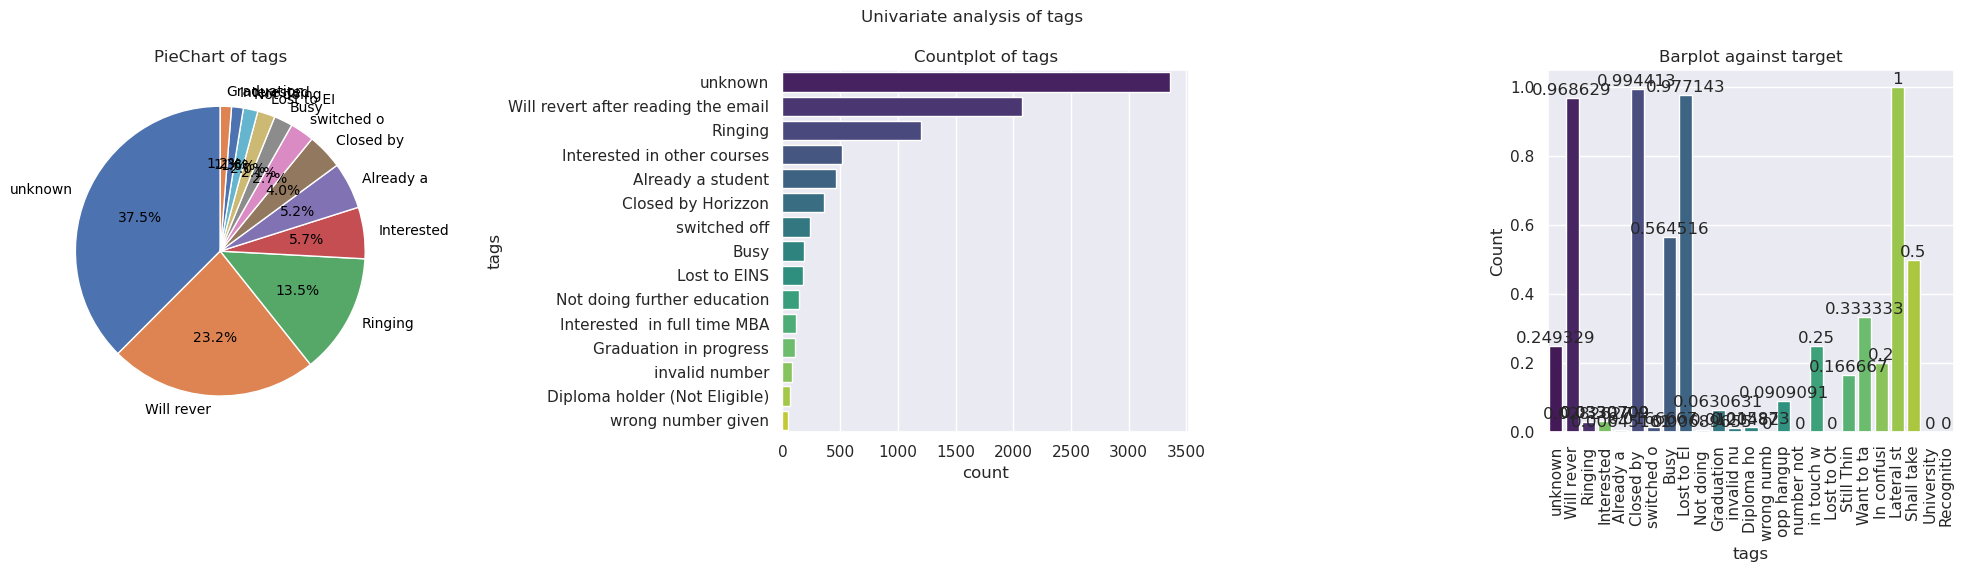

<Figure size 640x480 with 0 Axes>

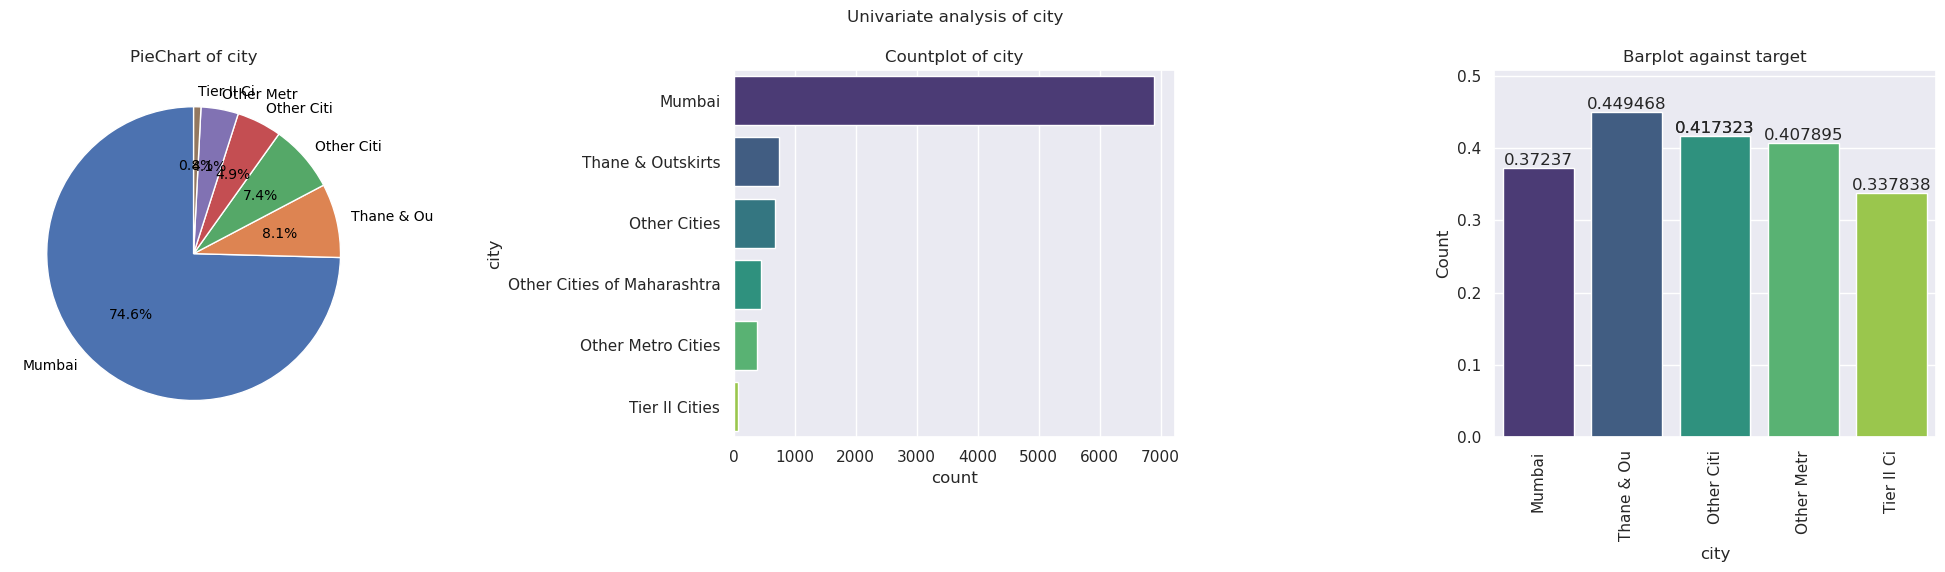

<Figure size 640x480 with 0 Axes>

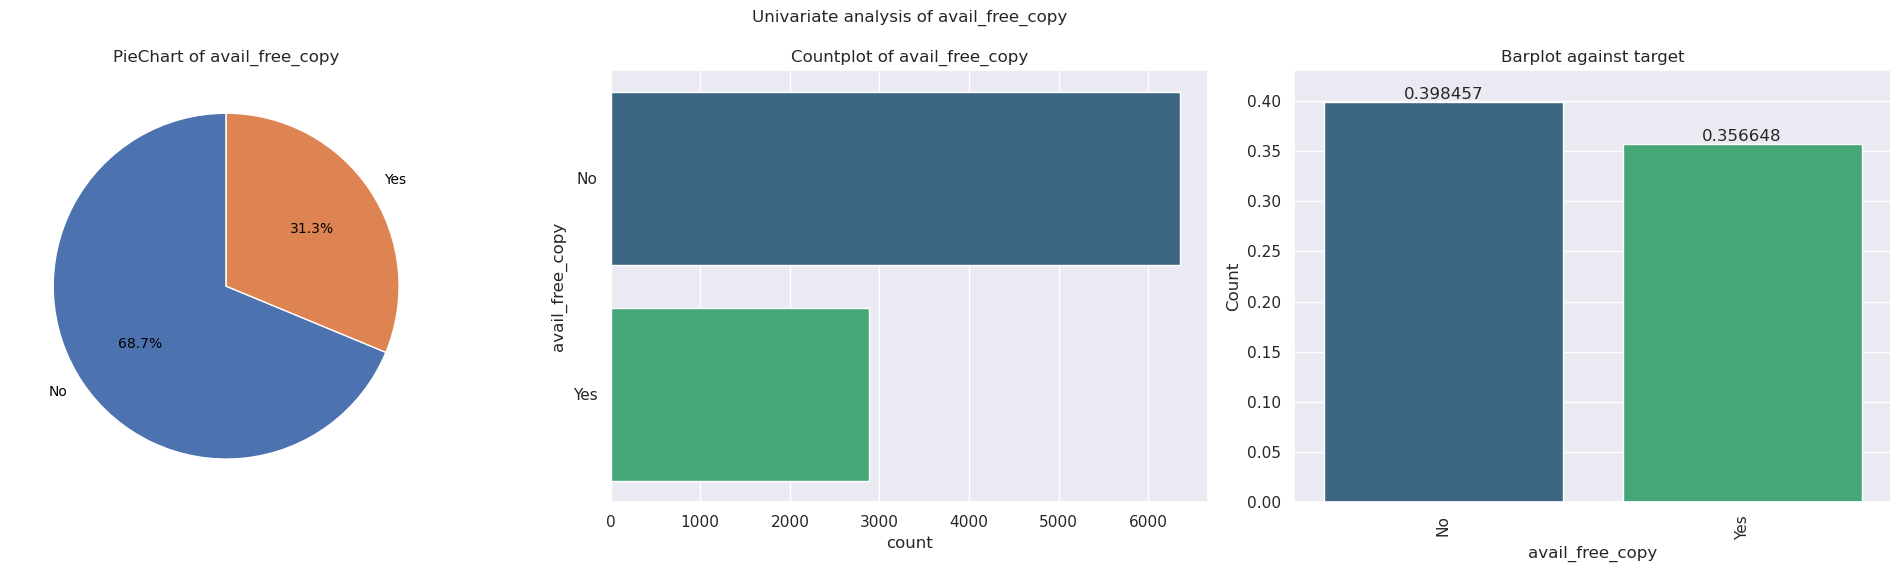

<Figure size 640x480 with 0 Axes>

In [1347]:
# univariate plots
cols = dtype_dict['int_cat'].copy()
cols.remove('converted')
univariate_plots(lead_score_df, cols, ftype='categorical', target='converted')

####  Observations

##### The categorical analysis
 - More than 50 per cent of the users are by originated landing page following which the apis have 38 of leeds
 - When it comes to lead origin conversion rates lead add form has higher conversion rates holistically all have similar probability rate
 
 - When it comes to lead source 30 are from google twenty seven percent are from direct traffic 19 are from olak chat
 
 - For the do not email feature 90 of them chose no while 7 of them chose yes therefore majority of them are interested in the edtech platform
 - Also the people who have said no also the users who said no have a higher percent of conversion rate
  
 - The last activity of majority of the users say 38 of users are email opened followed by sms sent therefore we can say that
 - Majority of the users are active on email conversations
  
 - Majority of the users are from india
 - We can we can assume that air tech has a higher popularity in india or higher interest in india higher demand in india
 
 - Among the employed users most of the interested users have finance management as a specialization followed by human resource management and marketing management almost all specialization has a similar conversion rate
 
 - Majority of the users are unemployed followed by working professionals
 - Working professionals have a higher conversion rates while the user count is low in comparison to unemployed
  
 - Majority of the users have chosen better career prospects as a reason for opting for the course
 
 - The majority of the leads have been tagged under will revert after reading the email
 
 - Maximum number of leads have been from the city of mumbai followed by thane almost all categories have similar probabilities of conversion
  
 - 90 of the leads have opted not to free copy of the interview while 31 are opted for interview copy
 

####

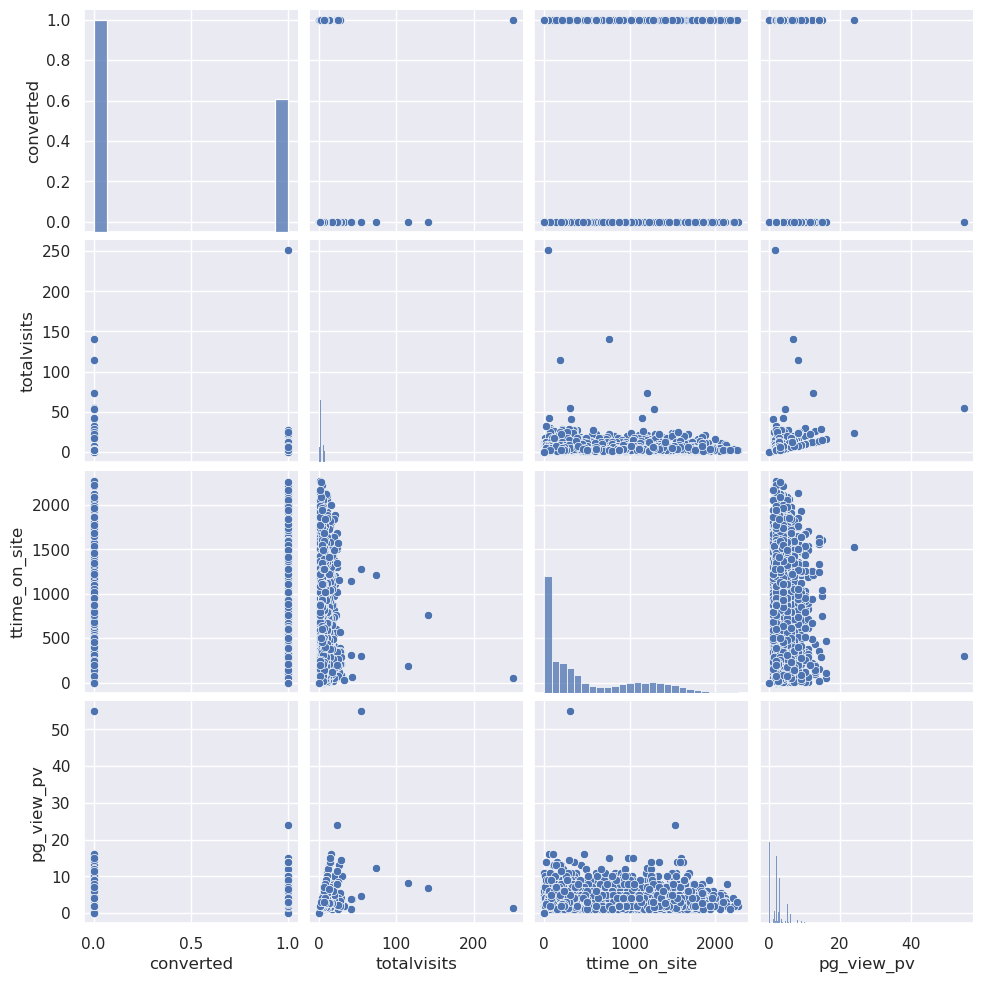

In [1348]:
# Bivariate plots
# The pair plot view shows that there is a slight correlation between total visits and page view per visit
sns.pairplot(lead_score_df)
plt.show();

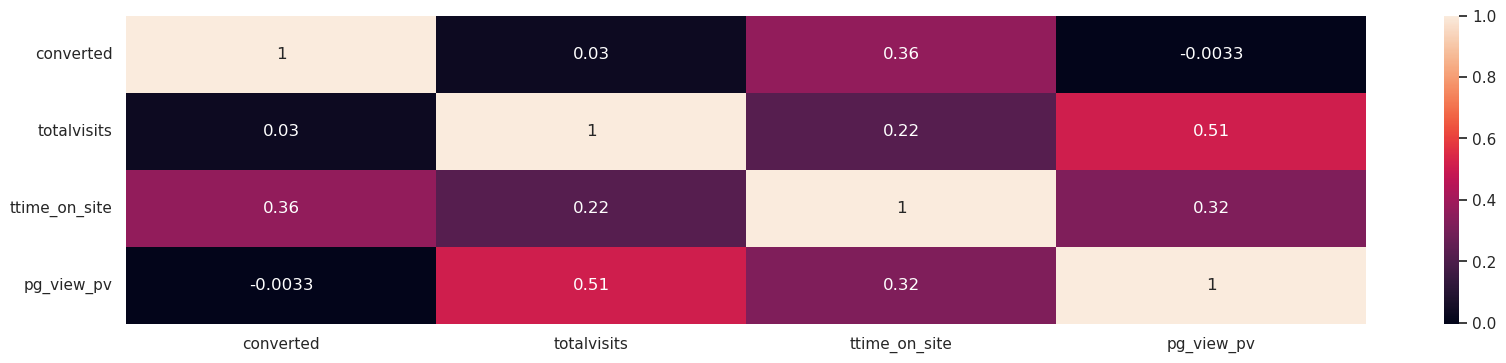

In [1349]:
# multivariate plots
# The heat map shows that majority of the features have no correlation or has lesser than 0 5 correlation

plt.figure(figsize = (20, 4)) # Size of the figure
sns.heatmap(lead_score_df.select_dtypes(exclude='category').corr(), annot = True)
plt.show();

#### 3.1 Other Bivariate - Multivariate plots (computationally intensive)

In [1350]:
# # Boxplots - numerical features against target

# axs = 141
# plt.figure(figsize=(26, 6))
# for i in list(set(dtype_dict['float_ts']) - set(['date','converted','lead_number'])):
#     plt.subplot(axs)
#     sns.boxplot(y=i, x='converted', data=lead_score_df, palette='tab10')
#     axs += 1
# plt.show();

In [1351]:
# # Generate Bivariate Boxplots combinations for all the categorical vs continuous columns

# x_lst = list(dtype_dict['int_cat']) # x_list variable contains all the categorical Columns 
# y_lst = list(dtype_dict['float_ts'])# y_list contains all Continuous feature type columns 
# axs = 1
# for x_col in x_lst:
#     plt.figure(figsize=(26,72))
#     for y_col in y_lst:
#         plt.subplot(18,4,axs)
#         sns.boxplot(x=x_col, y=y_col, data=lead_score_df, palette='tab10')
#         plt.xticks(rotation=90)
#         axs += 1
#     plt.show();
# plt.show();

In [1352]:
# # Generate Bivariate Barplots combinations for all the categorical features

# mplib.rcParams['ytick.labelsize'] = 8
# mplib.rcParams['xtick.labelsize'] = 8

# y_lst = x_lst = list(set(dtype_dict['int_cat']) - set(['converted','lead_number'])) # x_list variable contains all the categorical Columns 
# axs = 1
# for x_col in x_lst:
#     plt.figure(figsize=(25,400))
#     for y_col in y_lst:
        
#         # x_f = lead_score_df[x_col]
#         # y_f = lead_score_df[y_col]
            
#         # if isinstance(x_f,(object,'category')):
#         #     x_f = x_f.astype('str',copy=True).str.slice(0,10)
#         # if isinstance(y_f,(object,'category')):
#         #     y_f = y_f.astype('str',copy=True).str.slice(0,10)
        
#         plt.subplot(60,4,axs)
#         sns.barplot(x=x_col, y=y_col, hue ='converted' ,data=lead_score_df, palette='tab10')
#         plt.xticks(rotation=90)
#         # plt.ylabel(ylabel= lead_score_df[y_col].name, labelpad=-50)
#         # plt.locator_params(tight=True)
#         axs += 1
#     plt.show();
#     axs = 1
# plt.show();

In [1353]:
# # Multivariate Boxplots  - 

# mplib.rcParams['ytick.labelsize'] = 8
# mplib.rcParams['xtick.labelsize'] = 8
# # mplib.rcParams['ytick.major.size'] = 2
# # mplib.rcParams['xtick.major.size'] = 2

# z_lst = x_lst = list(dtype_dict['int_cat'])
# y_lst = list(dtype_dict['float_ts'])
# y_lst.remove('lead_number')
# axs = 1
# for x_col in x_lst:
#     for y_col in y_lst:
#         plt.figure(figsize=(25, 200))
#         for z_col in z_lst:
            
#             # x_f = lead_score_df[x_col]
#             # y_f = lead_score_df[y_col]
            
#             # if isinstance(x_f,(object,'category')):
#             #     x_f = x_f.astype('str',copy=True).str.slice(0,10)
#             # if isinstance(y_f,(object,'category')):
#             #     y_f = y_f.astype('str',copy=True).str.slice(0,10)
            
#             plt.subplot(25, 2, axs)
#             sns.boxplot(x=x_col, y=y_col, hue=z_col,hue_order=lead_score_df[z_col].value_counts().head(10).index ,data=lead_score_df, palette='tab10')
#             plt.xticks(rotation=90)
#             # plt.locator_params(tight=True)
#             plt.legend(loc='best')
#             axs += 1
#         plt.show();
#     axs = 1
#     print("--------------------------------------------------------------------------")
#     # break
# plt.show();

In [1354]:
# # Multivariate Boxplots  - 

# mplib.rcParams['ytick.labelsize'] = 8
# mplib.rcParams['xtick.labelsize'] = 8
# # mplib.rcParams['ytick.major.size'] = 2
# # mplib.rcParams['xtick.major.size'] = 2

# x_lst = list(dtype_dict['int_cat'])
# x_lst.remove('lead_origin')
# x_lst.remove('converted')
# z_lst = y_lst= x_lst
# axs = 1
# for x_col in x_lst:
#     for y_col in y_lst:
#             plt.figure(figsize=(25, 500))
#             for z_col in z_lst:
#                  if (x_col != y_col) & (y_col != z_col) & (x_col != z_col):
                         
#                 #     x_f = lead_score_df[x_col]
#                 #     y_f = lead_score_df[y_col]
#                 #     if isinstance(x_f,(object,'category')):
#                 #             x_f = x_f.astype('str',copy=True).str.slice(0,10)
#                 #     if isinstance(y_f,(object,'category')):
#                 #             y_f = y_f.astype('str',copy=True).str.slice(0,10)
                            
#                     plt.subplot(100, 3, axs)
#                     sns.barplot(x=x_col, y=y_col, hue=z_col, hue_order=lead_score_df[z_col].value_counts().head(10).index, data=lead_score_df, palette='tab10')
#                     plt.xticks(rotation=90)
#                 #     plt.ylabel(labelpad=3)
#                 #     plt.locator_params.set_label_coords(-0.01, 0.5)
#                     plt.legend(loc='best')
#                     axs += 1
#             plt.show()
#             axs = 1
#     print("--------------------------------------------------------------------------")
# plt.show();

###  ----------------------------------------------------------------------

### 4. Data Preprocesing - Part 2

#### Outlier Analysis and Capping

In [1355]:
# After performing eda we identified outliers in page view per visit totalvisits ttime on site columns we therefore cap all the values to the upper cut off and lower cut off of the iqr range

ex_val_df = get_extremeval_threshld(df=lead_score_df.select_dtypes(exclude=['category','object']) )
ex_val_df
lead_score_df.describe(percentiles=[.05,.1,.2,.5,.8,.9])

,thresh_low,thresh_high
name,,
converted,-1.500,2.500
totalvisits,-5.000,11.000
ttime_on_site,-1374.000,2322.000
pg_view_pv,-2.000,6.000


,converted,totalvisits,ttime_on_site,pg_view_pv
count,9240.000,9103.000,9240.000,9103.000
mean,0.385,3.445,487.698,2.363
std,0.487,4.855,548.021,2.161
min,0.000,0.000,0.000,0.000
5%,0.000,0.000,0.000,0.000
10%,0.000,0.000,0.000,0.000
20%,0.000,0.000,0.000,0.000
50%,0.000,3.000,248.000,2.000
80%,1.000,5.000,1087.200,4.000
90%,1.000,7.000,1380.000,5.000


In [1356]:
# Fix Outliers by setting either thresh low or thresh low for both extremes 
lower_cutoff = ex_val_df.loc['pg_view_pv','thresh_low']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] < lower_cutoff), lower_cutoff, lead_score_df['pg_view_pv'])
upper_cutoff = ex_val_df.loc['pg_view_pv','thresh_high']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] > upper_cutoff), upper_cutoff, lead_score_df['pg_view_pv'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['totalvisits','thresh_low']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] < lower_cutoff), lower_cutoff, lead_score_df['totalvisits'])
upper_cutoff = ex_val_df.loc['totalvisits','thresh_high']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] > upper_cutoff), upper_cutoff, lead_score_df['totalvisits'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['ttime_on_site','thresh_low']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] < lower_cutoff), lower_cutoff, lead_score_df['ttime_on_site'])
upper_cutoff = ex_val_df.loc['ttime_on_site','thresh_high']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] > upper_cutoff), upper_cutoff, lead_score_df['ttime_on_site'])

In [1357]:
lead_score_df.describe()

,converted,totalvisits,ttime_on_site,pg_view_pv
count,9240.000,9103.000,9240.000,9103.000
mean,0.385,3.221,487.698,2.259
std,0.487,2.882,548.021,1.793
min,0.000,0.000,0.000,0.000
25%,0.000,1.000,12.000,1.000
50%,0.000,3.000,248.000,2.000
75%,1.000,5.000,936.000,3.000
max,1.000,11.000,2272.000,6.000


In [1358]:
# Additionally there are few null values in their total visits and page view pub features therefore we replace with the mean of that particular column

lead_score_df['totalvisits'] = lead_score_df['totalvisits'].replace(to_replace=np.nan, value=lead_score_df['totalvisits'].median())
lead_score_df['pg_view_pv'] = lead_score_df['pg_view_pv'].replace(to_replace=np.nan, value=lead_score_df['pg_view_pv'].median())

In [1359]:
# replace Yes, No with 1 and 0
lead_score_df = lead_score_df.replace(to_replace=['Yes', 'No'], value=[1, 0])

In [1360]:
# our null values have significantly reduced
check_cols_null_pct(lead_score_df)
lead_score_df.shape

last_activity          1.115
lead_source            0.390
lead_origin            0.000
do_not_email           0.000
converted              0.000
totalvisits            0.000
ttime_on_site          0.000
pg_view_pv             0.000
country                0.000
specialization         0.000
curr_occupation        0.000
reason_behind_course   0.000
tags                   0.000
city                   0.000
avail_free_copy        0.000
dtype: float64

(9240, 15)

In [1361]:
######!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!###<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<, verify dropping of last_Activity, lead score columns>>>>>>>>>>>>>>>>>>??????????

In [1362]:
lead_score_df.last_activity = lead_score_df.last_activity.fillna(lead_score_df.last_activity.mode()[0])
lead_score_df.last_activity.value_counts(normalize=True) * 100

lead_score_df.lead_source = lead_score_df.lead_source.fillna(lead_score_df.lead_source.mode()[0])
lead_score_df.lead_source.value_counts(normalize=True) * 100

last_activity
Email Opened                   38.312
SMS Sent                       29.708
Olark Chat Conversation        10.530
Page Visited on Website         6.926
Converted to Lead               4.632
Email Bounced                   3.528
Email Link Clicked              2.890
Form Submitted on Website       1.255
Unreachable                     1.006
Unsubscribed                    0.660
Had a Phone Conversation        0.325
Approached upfront              0.097
View in browser link Clicked    0.065
Email Received                  0.022
Email Marked Spam               0.022
Resubscribed to emails          0.011
Visited Booth in Tradeshow      0.011
Name: proportion, dtype: float64

lead_source
Google              31.429
Direct Traffic      27.522
Olark Chat          18.994
Organic Search      12.489
Reference            5.779
Welingak Website     1.537
Referral Sites       1.353
Facebook             0.595
bing                 0.065
google               0.054
Click2call           0.043
Press_Release        0.022
Social Media         0.022
Live Chat            0.022
WeLearn              0.011
Pay per Click Ads    0.011
NC_EDM               0.011
blog                 0.011
testone              0.011
welearnblog_Home     0.011
youtubechannel       0.011
Name: proportion, dtype: float64

In [1363]:
# lead_score_df.to_csv('spec_tag_analysis.csv')

lead_score_df = lead_score_df.drop(['country'], axis=1)
null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct>0] ### there are no null values

lead_score_df.shape

Series([], dtype: float64)

(9240, 14)

In [1364]:
lead_score_df.dtypes

lead_origin             category
lead_source             category
do_not_email            category
converted                  int64
totalvisits              float64
ttime_on_site            float64
pg_view_pv               float64
last_activity           category
specialization          category
curr_occupation         category
reason_behind_course    category
tags                    category
city                    category
avail_free_copy         category
dtype: object

###  ----------------------------------------------------------------------

### 5. Data Imbalance & Conversion Ratio

In [1365]:
# Data Imbalance
# From the target variable we have found out the imbalance ratios around 62 therefore we decide not to rebalance

imbalance_ratio = sum(lead_score_df['converted'] == 1)/sum(lead_score_df['converted'] == 0) * 100
print(f'{round(imbalance_ratio, 2)}%')

62.7%


In [1366]:
# Conversion Ratio 
# From the target variable the conversion ratio is around 38 it shows that there is a very high probability of failure in conversion

converted = (sum(lead_score_df['converted'])/len(lead_score_df['converted'].index))*100
print(f'{round(converted, 2)}%')

38.54%


##  -----------------------------------------------------

In [1367]:
errorline # do no remove this line

NameError: name 'errorline' is not defined

## -----------------------------------------------------

## Approach - 01

### Data Encoding

#### Dummy Encoding

In [1137]:
#  we perform dummy encoding
new_ls_df = pd.get_dummies(lead_score_df, columns=lead_score_df.select_dtypes('category').columns.difference(['tags','specialization']), drop_first=True, dtype=float)
new_ls_df.head(1)
new_ls_df.shape

,converted,totalvisits,ttime_on_site,pg_view_pv,specialization,tags,avail_free_copy_1,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,curr_occupation_Housewife,curr_occupation_Other,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Working Professional,do_not_email_1,last_activity_Converted to Lead,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Marked Spam,last_activity_Email Opened,last_activity_Email Received,last_activity_Form Submitted on Website,last_activity_Had a Phone Conversation,last_activity_Olark Chat Conversation,last_activity_Page Visited on Website,last_activity_Resubscribed to emails,last_activity_SMS Sent,last_activity_Unreachable,last_activity_Unsubscribed,last_activity_View in browser link Clicked,last_activity_Visited Booth in Tradeshow,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Lead Import,lead_origin_Quick Add Form,lead_source_Direct Traffic,lead_source_Facebook,lead_source_Google,lead_source_Live Chat,lead_source_NC_EDM,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Pay per Click Ads,lead_source_Press_Release,lead_source_Reference,lead_source_Referral Sites,lead_source_Social Media,lead_source_WeLearn,lead_source_Welingak Website,lead_source_bing,lead_source_blog,lead_source_google,lead_source_testone,lead_source_welearnblog_Home,lead_source_youtubechannel,reason_behind_course_Flexibility & Convenience,reason_behind_course_Other
0,0,0.000,0.000,0.000,unknown,Interested in other courses,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


(9240, 60)

In [1138]:
new_ls_df = pd.get_dummies(new_ls_df, columns=['tags','specialization'], dtype=float)
new_ls_df = new_ls_df.drop(['tags_unknown','specialization_unknown'], axis=1)
new_ls_df.shape

(9240, 102)

###  ----------------------------------------------------------------------

### Train and Test Split

In [1139]:
X = new_ls_df.drop(['converted'], axis=1)
y = new_ls_df['converted']

In [1140]:
# Now we split the dataset into train and test set
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

###  ----------------------------------------------------------------------

### Feature Scaling

In [1141]:
new_ls_df.dtypes

converted                                                   int64
totalvisits                                               float64
ttime_on_site                                             float64
pg_view_pv                                                float64
avail_free_copy_1                                         float64
city_Other Cities                                         float64
city_Other Cities of Maharashtra                          float64
city_Other Metro Cities                                   float64
city_Thane & Outskirts                                    float64
city_Tier II Cities                                       float64
curr_occupation_Housewife                                 float64
curr_occupation_Other                                     float64
curr_occupation_Student                                   float64
curr_occupation_Unemployed                                float64
curr_occupation_Working Professional                      float64
do_not_ema

In [1142]:
# Post split we perform standard scaling they fit and transform the train data set
# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']

to_scale = list(X.columns)
to_scale

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale], y_train)
X_train.head(1)

['totalvisits',
 'ttime_on_site',
 'pg_view_pv',
 'avail_free_copy_1',
 'city_Other Cities',
 'city_Other Cities of Maharashtra',
 'city_Other Metro Cities',
 'city_Thane & Outskirts',
 'city_Tier II Cities',
 'curr_occupation_Housewife',
 'curr_occupation_Other',
 'curr_occupation_Student',
 'curr_occupation_Unemployed',
 'curr_occupation_Working Professional',
 'do_not_email_1',
 'last_activity_Converted to Lead',
 'last_activity_Email Bounced',
 'last_activity_Email Link Clicked',
 'last_activity_Email Marked Spam',
 'last_activity_Email Opened',
 'last_activity_Email Received',
 'last_activity_Form Submitted on Website',
 'last_activity_Had a Phone Conversation',
 'last_activity_Olark Chat Conversation',
 'last_activity_Page Visited on Website',
 'last_activity_Resubscribed to emails',
 'last_activity_SMS Sent',
 'last_activity_Unreachable',
 'last_activity_Unsubscribed',
 'last_activity_View in browser link Clicked',
 'last_activity_Visited Booth in Tradeshow',
 'lead_origin_Landi

,totalvisits,ttime_on_site,pg_view_pv,avail_free_copy_1,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,curr_occupation_Housewife,curr_occupation_Other,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Working Professional,do_not_email_1,last_activity_Converted to Lead,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Marked Spam,last_activity_Email Opened,last_activity_Email Received,last_activity_Form Submitted on Website,last_activity_Had a Phone Conversation,last_activity_Olark Chat Conversation,last_activity_Page Visited on Website,last_activity_Resubscribed to emails,last_activity_SMS Sent,last_activity_Unreachable,last_activity_Unsubscribed,last_activity_View in browser link Clicked,last_activity_Visited Booth in Tradeshow,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Lead Import,lead_origin_Quick Add Form,lead_source_Direct Traffic,lead_source_Facebook,lead_source_Google,lead_source_Live Chat,lead_source_NC_EDM,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Pay per Click Ads,lead_source_Press_Release,lead_source_Reference,lead_source_Referral Sites,lead_source_Social Media,lead_source_WeLearn,lead_source_Welingak Website,lead_source_bing,lead_source_blog,lead_source_google,lead_source_testone,lead_source_welearnblog_Home,lead_source_youtubechannel,reason_behind_course_Flexibility & Convenience,reason_behind_course_Other,tags_Already a student,tags_Busy,tags_Closed by Horizzon,tags_Diploma holder (Not Eligible),tags_Graduation in progress,tags_In confusion whether part time or DLP,tags_Interested in full time MBA,tags_Interested in Next batch,tags_Interested in other courses,tags_Lateral student,tags_Lost to EINS,tags_Lost to Others,tags_Not doing further education,tags_Recognition issue (DEC approval),tags_Ringing,tags_Shall take in the next coming month,tags_Still Thinking,tags_University not recognized,tags_Want to take admission but has financial problems,tags_Will revert after reading the email,tags_in touch with EINS,tags_invalid number,tags_number not provided,tags_opp hangup,tags_switched off,tags_wrong number given,"specialization_Banking, Investment And Insurance",specialization_Business Administration,specialization_E-Business,specialization_E-COMMERCE,specialization_Finance Management,specialization_Healthcare Management,specialization_Hospitality Management,specialization_Human Resource Management,specialization_IT Projects Management,specialization_International Business,specialization_Marketing Management,specialization_Media and Advertising,specialization_Operations Management,specialization_Retail Management,specialization_Rural and Agribusiness,specialization_Services Excellence,specialization_Supply Chain Management,specialization_Travel and Tourism
295,0.623,-0.351,0.135,-0.680,-0.287,-0.231,-0.208,-0.297,-0.095,-0.031,-0.035,-0.152,0.340,-0.290,-0.291,-0.225,-0.191,5.778,-0.016,-0.785,-0.016,-0.110,-0.055,-0.344,-0.273,-0.012,-0.651,-0.099,-0.082,-0.026,-0.012,-1.063,-0.287,-0.078,-0.012,-0.622,-0.078,-0.671,-0.012,-0.012,-0.483,2.628,-0.012,-0.016,-0.246,-0.118,-0.016,-0.012,-0.123,-0.026,-0.012,-0.020,-0.012,-0.012,-0.012,-0.016,0.000,-0.231,-0.141,-0.198,-0.080,-0.116,-0.020,-0.117,-0.023,-0.237,-0.020,-0.141,-0.026,-0.129,-0.012,-0.385,-0.016,-0.026,-0.016,-0.016,-0.538,-0.033,-0.093,-0.056,-0.061,-0.165,-0.071,-0.197,-0.216,-0.079,-0.111,-0.345,-0.136,-0.112,-0.315,-0.201,-0.138,-0.315,-0.150,-0.243,-0.107,-0.087,-0.065,-0.199,-0.149


###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [1143]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model

In [1144]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7291
Model Family:                Binomial   Df Model:                          100
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 20 Oct 2024   Deviance:                   1.0509e+05
Time:                        17:36:24   Pearson chi2:                 5.14e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
const                                                  -3.615e+13   7.81e+05  -4.63e+07      0.000   -3.61e+13   -3.61e+13
totalvisits                                             1.393e+14   1.29e+06   1.08e+08      0.000    1.39e+14    1.39e+14
ttime_on_site                                           4.441e+14   9.39e+05   4.73e+08      0.000    4.44e+14    4.44e+14
pg_view_pv                                             -1.829e+14   1.43e+06  -1.28e+08      0.000   -1.83e+14   -1.83e+14
avail_free_copy_1                                      -4.755e+13   1.18e+06  -4.04e+07      0.000   -4.76e+13   -4.76e+13
city_Other Cities                                      -1.373e+13   8.36e+05  -1.64e+07      0.000   -1.37e+13   -1.37e+13
city_Other Cities of Maharashtra                        8.432e+12   8.28e+05   1.02e+07      0.000    8.43e+12    8.43e+12
city_Other Metro Cities                                 4.839e+12   8.24e+05   5.87e+06      0.000    4.84e+12    4.84e+12
city_Thane & Outskirts                                 -3.447e+13   8.27e+05  -4.17e+07      0.000   -3.45e+13   -3.45e+13
city_Tier II Cities                                     1.438e+13   7.96e+05   1.81e+07      0.000    1.44e+13    1.44e+13
curr_occupation_Housewife                               5.945e+13   1.07e+06   5.53e+07      0.000    5.94e+13    5.94e+13
curr_occupation_Other                                   1.883e+12   1.14e+06   1.65e+06      0.000    1.88e+12    1.88e+12
curr_occupation_Student                                 6.829e+13   3.65e+06   1.87e+07      0.000    6.83e+13    6.83e+13
curr_occupation_Unemployed                              4.176e+13   7.28e+06   5.74e+06      0.000    4.18e+13    4.18e+13
curr_occupation_Working Professional                    9.615e+13   6.42e+06    1.5e+07      0.000    9.61e+13    9.61e+13
do_not_email_1                                         -1.621e+14   1.13e+06  -1.44e+08      0.000   -1.62e+14   -1.62e+14
last_activity_Converted to Lead                         -8.01e+14   5.54e+06  -1.45e+08      0.000   -8.01e+14   -8.01e+14
last_activity_Email Bounced                            -6.055e+14   4.84e+06  -1.25e+08      0.000   -6.05e+14   -6.05e+14
last_activity_Email Link Clicked                       -5.752e+14   4.37e+06  -1.32e+08      0.000   -5.75e+14   -5.75e+14
last_activity_Email Marked Spam                         1.419e+13   8.91e+05   1.59e+07      0.000    1.42e+13    1.42e+13
last_activity_Email Opened                             -1.504e+15   1.24e+07  -1.21e+08      0.000    -1.5e+15    -1.5e+15
last_activity_Email Received                            1.812e+12    8.9e+05   2.04e+06      0.000    1.81e+12    1.81e+12
last_act

##### RFE - Recursive Feature Elimination

In [1145]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features
logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('totalvisits', False, 7),
 ('ttime_on_site', True, 1),
 ('pg_view_pv', False, 6),
 ('avail_free_copy_1', False, 26),
 ('city_Other Cities', False, 75),
 ('city_Other Cities of Maharashtra', False, 85),
 ('city_Other Metro Cities', False, 86),
 ('city_Thane & Outskirts', False, 53),
 ('city_Tier II Cities', False, 77),
 ('curr_occupation_Housewife', False, 19),
 ('curr_occupation_Other', False, 80),
 ('curr_occupation_Student', False, 29),
 ('curr_occupation_Unemployed', False, 76),
 ('curr_occupation_Working Professional', False, 14),
 ('do_not_email_1', False, 5),
 ('last_activity_Converted to Lead', False, 4),
 ('last_activity_Email Bounced', False, 13),
 ('last_activity_Email Link Clicked', False, 23),
 ('last_activity_Email Marked Spam', False, 34),
 ('last_activity_Email Opened', False, 24),
 ('last_activity_Email Received', False, 52),
 ('last_activity_Form Submitted on Website', False, 25),
 ('last_activity_Had a Phone Conversation', False, 22),
 ('last_activity_Olark Chat Con

In [1146]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index(['totalvisits', 'pg_view_pv', 'avail_free_copy_1', 'city_Other Cities',
       'city_Other Cities of Maharashtra', 'city_Other Metro Cities',
       'city_Thane & Outskirts', 'city_Tier II Cities',
       'curr_occupation_Housewife', 'curr_occupation_Other',
       'curr_occupation_Student', 'curr_occupation_Unemployed',
       'curr_occupation_Working Professional', 'do_not_email_1',
       'last_activity_Converted to Lead', 'last_activity_Email Bounced',
       'last_activity_Email Link Clicked', 'last_activity_Email Marked Spam',
       'last_activity_Email Opened', 'last_activity_Email Received',
       'last_activity_Form Submitted on Website',
       'last_activity_Had a Phone Conversation',
       'last_activity_Page Visited on Website',
       'last_activity_Resubscribed to emails', 'last_activity_Unreachable',
       'last_activity_Unsubscribed',
       'last_activity_View in browser link Clicked',
       'last_activity_Visited Booth in Tradeshow', 'lead_origin_Lead Add 

##### Model 1

In [1147]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7376
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1616.6
Date:                Sun, 20 Oct 2024   Deviance:                       3233.2
Time:                        17:36:30   Pearson chi2:                 8.74e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.5912
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.9449    123.819     -0.008      0.994    -243.625     241.735
ttime_on_site                                0.9175      0.048     18.981      0.000       0.823       1.012
last_activity_Olark Chat Conversation       -0.3834      0.063     -6.096      0.000      -0.507      -0.260
last_activity_SMS Sent                       0.9121      0.046     19.711      0.000       0.821       1.003
lead_origin_Landing Page Submission         -0.5493      0.051    -10.855      0.000      -0.649      -0.450
lead_source_Welingak Website                 0.5968      0.089      6.738      0.000       0.423       0.770
tags_Already a student                      -0.7295      0.157     -4.638      0.000      -1.038      -0.421
tags_Closed by Horizzon                      1.2741      0.136      9.340      0.000       1.007       1.542
tags_Interested in other courses            -0.4534      0.072     -6.292      0.000      -0.595      -0.312
tags_Lost to EINS                            0.7436      0.072     10.278      0.000       0.602       0.885
tags_Not doing further education            -0.3928      0.129     -3.045      0.002      -0.646      -0.140
tags_Ringing                                -0.9265      0.070    -13.271      0.000      -1.063      -0.790
tags_Will revert after reading the email     1.9197      0.064     30.015      0.000       1.794       2.045
tags_number not provided                    -1.3250   1360.550     -0.001      0.999   -2667.953    2665.303
tags_switched off                           -0.5130      0.084     -6.102      0.000      -0.678      -0.348
tags_wrong number given                     -1.6550   1378.069     -0.001      0.999   -2702.622    2699.312
============================================================================================================
"""


VIF Score:


,Features,VIF
11,tags_Will revert after reading the email,1.340
3,lead_origin_Landing Page Submission,1.240
1,last_activity_Olark Chat Conversation,1.220
0,ttime_on_site,1.210
10,tags_Ringing,1.180
2,last_activity_SMS Sent,1.160
5,tags_Already a student,1.080
6,tags_Closed by Horizzon,1.080
7,tags_Interested in other courses,1.080
4,lead_source_Welingak Website,1.050


##### Model 2

In [1148]:
# col = col.drop('curr_occupation_Housewife', 1)
# col

col = col.drop('tags_number not provided', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['ttime_on_site', 'last_activity_Olark Chat Conversation',
       'last_activity_SMS Sent', 'lead_origin_Landing Page Submission',
       'lead_source_Welingak Website', 'tags_Already a student',
       'tags_Closed by Horizzon', 'tags_Interested in other courses',
       'tags_Lost to EINS', 'tags_Not doing further education', 'tags_Ringing',
       'tags_Will revert after reading the email', 'tags_switched off',
       'tags_wrong number given'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7377
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1624.4
Date:                Sun, 20 Oct 2024   Deviance:                       3248.8
Time:                        17:36:30   Pearson chi2:                 8.74e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.5903
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.8707     59.327     -0.015      0.988    -117.150     115.409
ttime_on_site                                0.9124      0.048     18.952      0.000       0.818       1.007
last_activity_Olark Chat Conversation       -0.3823      0.063     -6.076      0.000      -0.506      -0.259
last_activity_SMS Sent                       0.9086      0.046     19.700      0.000       0.818       0.999
lead_origin_Landing Page Submission         -0.5548      0.051    -10.978      0.000      -0.654      -0.456
lead_source_Welingak Website                 0.5972      0.089      6.744      0.000       0.424       0.771
tags_Already a student                      -0.7260      0.157     -4.616      0.000      -1.034      -0.418
tags_Closed by Horizzon                      1.2760      0.136      9.353      0.000       1.009       1.543
tags_Interested in other courses            -0.4502      0.072     -6.254      0.000      -0.591      -0.309
tags_Lost to EINS                            0.7454      0.072     10.305      0.000       0.604       0.887
tags_Not doing further education            -0.3904      0.129     -3.027      0.002      -0.643      -0.138
tags_Ringing                                -0.9194      0.070    -13.187      0.000      -1.056      -0.783
tags_Will revert after reading the email     1.9253      0.064     30.113      0.000       1.800       2.051
tags_switched off                           -0.5096      0.084     -6.063      0.000      -0.674      -0.345
tags_wrong number given                     -1.5828    836.460     -0.002      0.998   -1641.014    1637.848
============================================================================================================
"""


VIF Score:


,Features,VIF
11,tags_Will revert after reading the email,1.330
3,lead_origin_Landing Page Submission,1.240
0,ttime_on_site,1.210
1,last_activity_Olark Chat Conversation,1.210
10,tags_Ringing,1.170
2,last_activity_SMS Sent,1.160
5,tags_Already a student,1.080
6,tags_Closed by Horizzon,1.080
7,tags_Interested in other courses,1.080
4,lead_source_Welingak Website,1.050


##### Model 3

In [1149]:
#tags_Diploma holder (Not Eligible)

# col = col.drop('tags_Diploma holder (Not Eligible)', 1)
# col

# cutoff = 0.5
# res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
# confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
# vif = logreg_VIF_score_fn(X_train, col)

# print('Model Summary:')          # Model Summary:
# res.summary()
# print('\nVIF Score:')            # VIF Score:
# vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:

####  ----------------------------------------------------------------------

##### Model 4

In [1150]:
#tags_Diploma holder (Not Eligible)

col = col.drop('tags_wrong number given', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

Index(['ttime_on_site', 'last_activity_Olark Chat Conversation',
       'last_activity_SMS Sent', 'lead_origin_Landing Page Submission',
       'lead_source_Welingak Website', 'tags_Already a student',
       'tags_Closed by Horizzon', 'tags_Interested in other courses',
       'tags_Lost to EINS', 'tags_Not doing further education', 'tags_Ringing',
       'tags_Will revert after reading the email', 'tags_switched off'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7378
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1634.4
Date:                Sun, 20 Oct 2024   Deviance:                       3268.8
Time:                        17:36:31   Pearson chi2:                 8.75e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5892
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.7666      0.073    -10.507      0.000      -0.910      -0.624
ttime_on_site                                0.9137      0.048     19.043      0.000       0.820       1.008
last_activity_Olark Chat Conversation       -0.3820      0.063     -6.066      0.000      -0.505      -0.259
last_activity_SMS Sent                       0.9014      0.046     19.616      0.000       0.811       0.991
lead_origin_Landing Page Submission         -0.5654      0.050    -11.209      0.000      -0.664      -0.467
lead_source_Welingak Website                 0.5983      0.089      6.757      0.000       0.425       0.772
tags_Already a student                      -0.7222      0.157     -4.591      0.000      -1.031      -0.414
tags_Closed by Horizzon                      1.2788      0.136      9.374      0.000       1.011       1.546
tags_Interested in other courses            -0.4469      0.072     -6.211      0.000      -0.588      -0.306
tags_Lost to EINS                            0.7480      0.072     10.341      0.000       0.606       0.890
tags_Not doing further education            -0.3876      0.129     -3.005      0.003      -0.640      -0.135
tags_Ringing                                -0.9103      0.070    -13.071      0.000      -1.047      -0.774
tags_Will revert after reading the email     1.9336      0.064     30.243      0.000       1.808       2.059
tags_switched off                           -0.5049      0.084     -6.008      0.000      -0.670      -0.340
============================================================================================================
"""


VIF Score:


,Features,VIF
11,tags_Will revert after reading the email,1.330
3,lead_origin_Landing Page Submission,1.240
0,ttime_on_site,1.210
1,last_activity_Olark Chat Conversation,1.210
10,tags_Ringing,1.170
2,last_activity_SMS Sent,1.160
5,tags_Already a student,1.080
6,tags_Closed by Horizzon,1.080
7,tags_Interested in other courses,1.070
4,lead_source_Welingak Website,1.050


In [1151]:
X_train.shape

(7392, 101)

In [1152]:
print('\nY_Predicted Values:')   # Y_Predicted Values:
y_train_pred
print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:


Y_Predicted Values:


array([0.16006767, 0.04594843, 0.99948323, ..., 0.00544959, 0.03252093,
       0.10985181])


Y_Predicted Cutoff:


,Converted,Conv_Prob,ID,predicted
0,0,0.160,295,0
1,0,0.046,1657,0
2,1,0.999,4592,1
3,0,0.104,3558,0
4,0,0.061,629,0
...,...,...,...,...
7387,1,0.952,7891,1
7388,0,0.041,9225,0
7389,0,0.005,4859,0
7390,0,0.033,3264,0



Confusion Matrix:


array([[4354,  200],
       [ 462, 2376]])


Accuracy Score: 0.9104437229437229



#### Finding Optimal Cutoff Point

In [1153]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900
0,0,0.160,295,0,1,1,0,0,0,0,0,0,0,0
1,0,0.046,1657,0,1,0,0,0,0,0,0,0,0,0
2,1,0.999,4592,1,1,1,1,1,1,1,1,1,1,1
3,0,0.104,3558,0,1,1,0,0,0,0,0,0,0,0
4,0,0.061,629,0,1,0,0,0,0,0,0,0,0,0


In [1154]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.384  1.000  0.000
0.100 0.100     0.797  0.977  0.686
0.200 0.200     0.886  0.933  0.857
0.300 0.300     0.911  0.909  0.913
0.400 0.400     0.917  0.889  0.934
0.500 0.500     0.910  0.837  0.956
0.600 0.600     0.911  0.818  0.969
0.700 0.700     0.908  0.797  0.977
0.800 0.800     0.899  0.767  0.982
0.900 0.900     0.881  0.708  0.989


<Axes: xlabel='prob'>

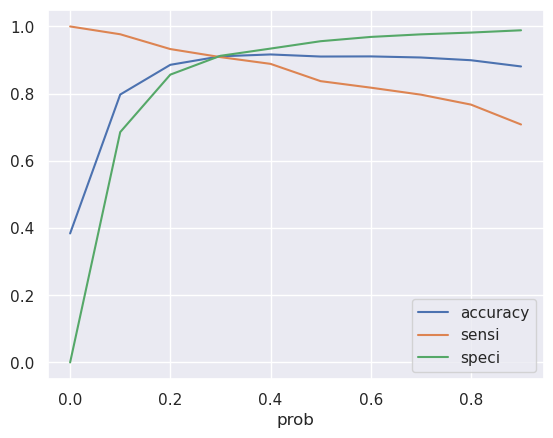

In [1155]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [1156]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.29 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,final_predicted
0,0,0.160,295,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.046,1657,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0.999,4592,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0.104,3558,0,1,1,0,0,0,0,0,0,0,0,0
4,0,0.061,629,0,1,0,0,0,0,0,0,0,0,0,0


In [1157]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.9084145021645021

In [1158]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[4132,  422],
       [ 255, 2583]])

####  ----------------------------------------------------------------------

#### ROC Curve and Precision - Recall Curve

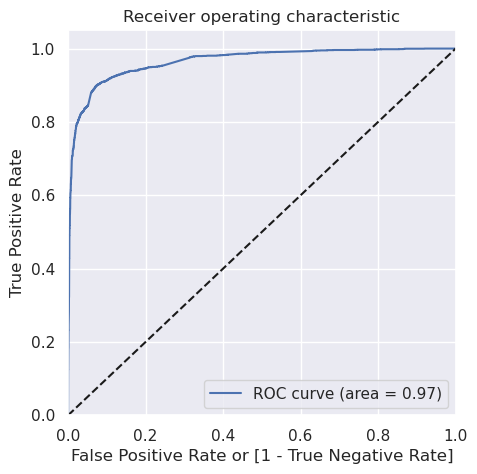

In [1159]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [1160]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.922360248447205

0.8372093023255814

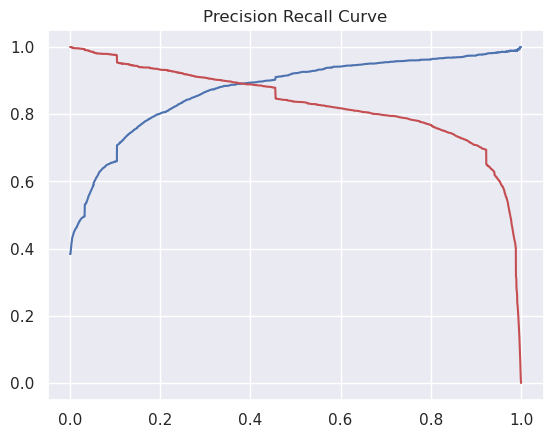

In [1161]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

In [1162]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.39 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,final_predicted
0,0,0.160,295,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.046,1657,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0.999,4592,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0.104,3558,0,1,1,0,0,0,0,0,0,0,0,0
4,0,0.061,629,0,1,0,0,0,0,0,0,0,0,0,0


In [1163]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.9159902597402597

In [1164]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[4248,  306],
       [ 315, 2523]])

###  ---------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [1165]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [1166]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head(2)
X_test.shape

,ttime_on_site,last_activity_Olark Chat Conversation,last_activity_SMS Sent,lead_origin_Landing Page Submission,lead_source_Welingak Website,tags_Already a student,tags_Closed by Horizzon,tags_Interested in other courses,tags_Lost to EINS,tags_Not doing further education,tags_Ringing,tags_Will revert after reading the email,tags_switched off
2212,1.110,-0.344,-0.651,-1.063,-0.123,-0.231,-0.198,-0.237,-0.141,-0.129,-0.385,-0.538,6.075
3034,1.380,-0.344,-0.651,-1.063,-0.123,-0.231,-0.198,-0.237,7.095,-0.129,-0.385,-0.538,-0.165


(1848, 101)

In [1167]:
cutoff = 0.39
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif


Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7378
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1634.4
Date:                Sun, 20 Oct 2024   Deviance:                       3268.8
Time:                        17:36:32   Pearson chi2:                 8.75e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5892
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.7666      0.073    -10.507      0.000      -0.910      -0.624
ttime_on_site                                0.9137      0.048     19.043      0.000       0.820       1.008
last_activity_Olark Chat Conversation       -0.3820      0.063     -6.066      0.000      -0.505      -0.259
last_activity_SMS Sent                       0.9014      0.046     19.616      0.000       0.811       0.991
lead_origin_Landing Page Submission         -0.5654      0.050    -11.209      0.000      -0.664      -0.467
lead_source_Welingak Website                 0.5983      0.089      6.757      0.000       0.425       0.772
tags_Already a student                      -0.7222      0.157     -4.591      0.000      -1.031      -0.414
tags_Closed by Horizzon                      1.2788      0.136      9.374      0.000       1.011       1.546
tags_Interested in other courses            -0.4469      0.072     -6.211      0.000      -0.588      -0.306
tags_Lost to EINS                            0.7480      0.072     10.341      0.000       0.606       0.890
tags_Not doing further education            -0.3876      0.129     -3.005      0.003      -0.640      -0.135
tags_Ringing                                -0.9103      0.070    -13.071      0.000      -1.047      -0.774
tags_Will revert after reading the email     1.9336      0.064     30.243      0.000       1.808       2.059
tags_switched off                           -0.5049      0.084     -6.008      0.000      -0.670      -0.340
============================================================================================================
"""


VIF Score:


,Features,VIF
11,tags_Will revert after reading the email,1.330
3,lead_origin_Landing Page Submission,1.240
0,ttime_on_site,1.200
10,tags_Ringing,1.200
1,last_activity_Olark Chat Conversation,1.190
2,last_activity_SMS Sent,1.170
6,tags_Closed by Horizzon,1.100
7,tags_Interested in other courses,1.100
5,tags_Already a student,1.080
4,lead_source_Welingak Website,1.060


In [1168]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Confusion Matrix:


array([[1057,   68],
       [  71,  652]])


Accuracy Score: 0.9247835497835498



## Approach - 01 - Accuracy Score:

In [1169]:
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Accuracy Score: 0.9247835497835498



## -----------------------------------------------------

In [1170]:
errorline # do no remove this line

NameError: name 'errorline' is not defined

## -----------------------------------------------------

## Approach - 02

### Data Encoding

#### Label Encoding

In [1288]:
# for label_encoding:
# Since there are many categorical features with nominal values 5 we decide to use label encoding for those features

cols_to_le = lead_score_df.select_dtypes('category').columns
cols_to_le

Index(['lead_origin', 'lead_source', 'do_not_email', 'last_activity',
       'specialization', 'curr_occupation', 'reason_behind_course', 'tags',
       'city', 'avail_free_copy'],
      dtype='object')

In [1289]:
df_le = lead_score_df.copy()

le = LabelEncoder()
df_le[cols_to_le] = lead_score_df[cols_to_le].apply(le.fit_transform)

<Figure size 1000x600 with 0 Axes>

<Axes: >

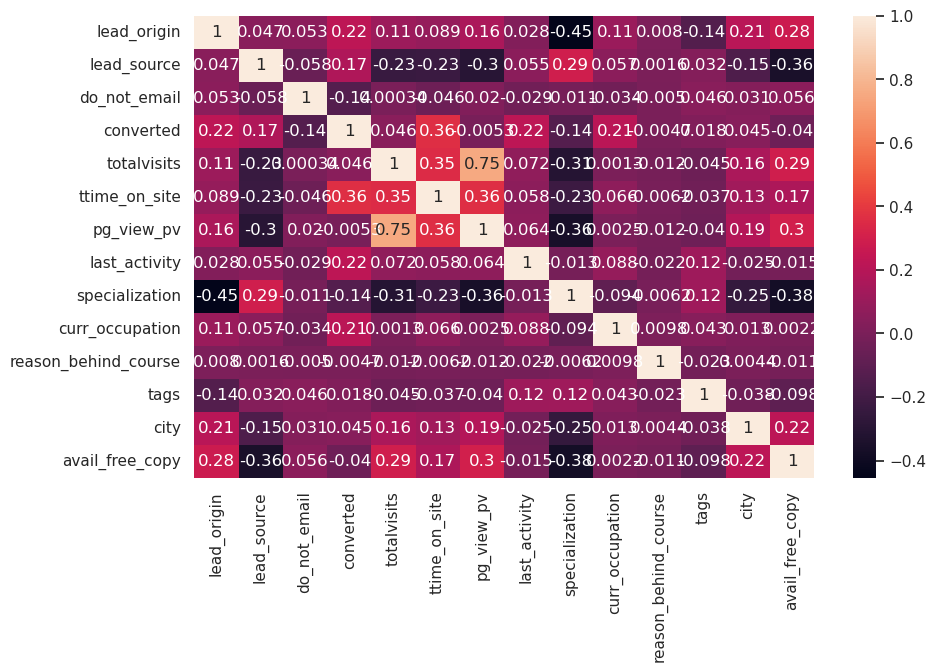

In [1290]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_le.corr(), annot=True)

In [1291]:
# We then merged the encoder features with the non encoded features and name it as new lsdf

# new_ls_df = lead_score_df[lead_score_df.columns.difference(cols_to_le)]
# new_ls_df = new_ls_df.merge(right=df_le, right_index=True, left_index=True)
df_le.head(1)

,lead_origin,lead_source,do_not_email,converted,totalvisits,ttime_on_site,pg_view_pv,last_activity,specialization,curr_occupation,reason_behind_course,tags,city,avail_free_copy
0,0,6,0,0,0.000,0.000,0.000,10,18,4,0,8,0,0


In [1292]:
# our null values have significantly reduced
null_pct = check_cols_null_pct(df_le)
null_pct[null_pct>0]
df_le.shape

Series([], dtype: float64)

(9240, 14)

In [1293]:
# new_ls_df = new_ls_df[(new_ls_df.notna()).all(axis=1)]
# check_cols_null_pct(new_ls_df)
# sorted([f'{i} - {new_ls_df[i].unique()}' for i in new_ls_df.columns])

###  ----------------------------------------------------------------------

### Train and Test Split

In [1294]:
X = df_le.drop(['converted'], axis=1)
y = df_le['converted']

In [1295]:
# Now we split the dataset into train and test set
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

###  ----------------------------------------------------------------------

### Feature Scaling

In [1296]:
# Post split we perform standard scaling they fit and transform the train data set

# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = ['totalvisits', 'ttime_on_site', 'pg_view_pv', 'lead_source', 'last_activity', 'curr_occupation']

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale],y_train)
X_train.head()

,lead_origin,lead_source,do_not_email,totalvisits,ttime_on_site,pg_view_pv,last_activity,specialization,curr_occupation,reason_behind_course,tags,city,avail_free_copy
295,0,0.918,0,0.623,-0.351,0.135,-1.276,18,-0.126,0,25,0,0
1657,0,0.589,0,-0.777,-0.498,-0.708,0.363,18,-0.126,0,25,0,0
4592,0,-0.399,0,-0.427,2.517,-0.708,1.182,1,-0.126,0,19,0,0
3558,0,0.589,0,-1.127,-0.892,-1.269,-0.730,18,-0.126,0,25,0,0
629,1,-1.057,0,0.273,-0.296,0.977,-0.730,4,-0.126,0,25,2,1


###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [1297]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model 1

In [1298]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7378
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3591.9
Date:                Sun, 20 Oct 2024   Deviance:                       7183.8
Time:                        17:38:03   Pearson chi2:                 9.09e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3024
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.4760      0.119     -4.002      0.000      -0.709      -0.243
lead_origin              0.6532      0.054     12.077      0.000       0.547       0.759
lead_source              0.5352      0.035     15.348      0.000       0.467       0.604
do_not_email            -1.3020      0.137     -9.522      0.000      -1.570      -1.034
totalvisits              0.0977      0.044      2.208      0.027       0.011       0.184
ttime_on_site            1.0524      0.034     30.960      0.000       0.986       1.119
pg_view_pv              -0.4748      0.047    -10.105      0.000      -0.567      -0.383
last_activity            0.5353      0.031     17.310      0.000       0.475       0.596
specialization          -0.0472      0.006     -7.935      0.000      -0.059      -0.036
curr_occupation          0.4249      0.036     11.781      0.000       0.354       0.496
reason_behind_course    -0.3050      1.976     -0.154      0.877      -4.179       3.569
tags                     0.0103      0.004      2.691      0.007       0.003       0.018
city                     0.0083      0.023      0.356      0.722      -0.037       0.054
avail_free_copy         -0.4305      0.073     -5.918      0.000      -0.573      -0.288
========================================================================================
"""

##### RFE - Recursive Feature Elimination

In [1299]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features

logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('lead_origin', True, 1),
 ('lead_source', True, 1),
 ('do_not_email', True, 1),
 ('totalvisits', True, 1),
 ('ttime_on_site', True, 1),
 ('pg_view_pv', True, 1),
 ('last_activity', True, 1),
 ('specialization', True, 1),
 ('curr_occupation', True, 1),
 ('reason_behind_course', True, 1),
 ('tags', True, 1),
 ('city', True, 1),
 ('avail_free_copy', True, 1)]

In [1300]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index([], dtype='object')

##### Model 1

In [1301]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7378
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3591.9
Date:                Sun, 20 Oct 2024   Deviance:                       7183.8
Time:                        17:38:03   Pearson chi2:                 9.09e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3024
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.4760      0.119     -4.002      0.000      -0.709      -0.243
lead_origin              0.6532      0.054     12.077      0.000       0.547       0.759
lead_source              0.5352      0.035     15.348      0.000       0.467       0.604
do_not_email            -1.3020      0.137     -9.522      0.000      -1.570      -1.034
totalvisits              0.0977      0.044      2.208      0.027       0.011       0.184
ttime_on_site            1.0524      0.034     30.960      0.000       0.986       1.119
pg_view_pv              -0.4748      0.047    -10.105      0.000      -0.567      -0.383
last_activity            0.5353      0.031     17.310      0.000       0.475       0.596
specialization          -0.0472      0.006     -7.935      0.000      -0.059      -0.036
curr_occupation          0.4249      0.036     11.781      0.000       0.354       0.496
reason_behind_course    -0.3050      1.976     -0.154      0.877      -4.179       3.569
tags                     0.0103      0.004      2.691      0.007       0.003       0.018
city                     0.0083      0.023      0.356      0.722      -0.037       0.054
avail_free_copy         -0.4305      0.073     -5.918      0.000      -0.573      -0.288
========================================================================================
"""


VIF Score:


,Features,VIF
10,tags,4.110
7,specialization,3.520
5,pg_view_pv,2.530
3,totalvisits,2.400
0,lead_origin,2.220
12,avail_free_copy,1.900
11,city,1.390
1,lead_source,1.320
4,ttime_on_site,1.210
2,do_not_email,1.110


##### Model 2

In [1302]:
# col = col.drop('avail_free_copy_1', 1)
# col

col = col.drop('tags', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['lead_origin', 'lead_source', 'do_not_email', 'totalvisits',
       'ttime_on_site', 'pg_view_pv', 'last_activity', 'specialization',
       'curr_occupation', 'reason_behind_course', 'city', 'avail_free_copy'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7379
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3595.6
Date:                Sun, 20 Oct 2024   Deviance:                       7191.1
Time:                        17:38:03   Pearson chi2:                 9.18e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3017
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2920      0.097     -3.009      0.003      -0.482      -0.102
lead_origin              0.6374      0.054     11.863      0.000       0.532       0.743
lead_source              0.5349      0.035     15.361      0.000       0.467       0.603
do_not_email            -1.2846      0.136     -9.416      0.000      -1.552      -1.017
totalvisits              0.0947      0.044      2.144      0.032       0.008       0.181
ttime_on_site            1.0508      0.034     30.944      0.000       0.984       1.117
pg_view_pv              -0.4714      0.047    -10.048      0.000      -0.563      -0.379
last_activity            0.5444      0.031     17.708      0.000       0.484       0.605
specialization          -0.0464      0.006     -7.816      0.000      -0.058      -0.035
curr_occupation          0.4263      0.036     11.865      0.000       0.356       0.497
reason_behind_course    -0.3844      1.974     -0.195      0.846      -4.253       3.484
city                     0.0090      0.023      0.386      0.700      -0.037       0.055
avail_free_copy         -0.4398      0.073     -6.057      0.000      -0.582      -0.298
========================================================================================
"""


VIF Score:


,Features,VIF
5,pg_view_pv,2.530
3,totalvisits,2.400
0,lead_origin,2.040
11,avail_free_copy,1.880
7,specialization,1.590
10,city,1.380
1,lead_source,1.310
4,ttime_on_site,1.210
2,do_not_email,1.100
8,curr_occupation,1.030


##### Model 3

In [1303]:
# col = col.drop('lead_origin_Quick Add Form')
# col

# cutoff = 0.5
# res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
# confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
# vif = logreg_VIF_score_fn(X_train, col)

# print('Model Summary:')          # Model Summary:
# res.summary()
# print('\nVIF Score:')            # VIF Score:
# vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

##### Model 4

In [1304]:
# col = col.drop('lead_origin_Lead Import')
# col

# cutoff = 0.5
# res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
# confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
# vif = logreg_VIF_score_fn(X_train, col)

# print('Model Summary:')          # Model Summary:
# res.summary()
# print('\nVIF Score:')            # VIF Score:
# vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:

##### Model 5

In [1305]:
# col = col.drop('lead_origin_Lead Import')
# col

# cutoff = 0.5
# res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
# confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
# vif = logreg_VIF_score_fn(X_train, col)

# print('Model Summary:')          # Model Summary:
# res.summary()
# print('\nVIF Score:')            # VIF Score:
# vif

# # print('\nY_Predicted Values:')   # Y_Predicted Values:
# # y_train_pred
# # print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# # y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:

##### Model 6

In [1306]:
# col = col.drop('reason_behind_course_Flexibility & Convenience')
# col

# cutoff = 0.5
# res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
# confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
# vif = logreg_VIF_score_fn(X_train, col)

# print('Model Summary:')          # Model Summary:
# res.summary()
# print('\nVIF Score:')            # VIF Score:
# vif

# # print('\nY_Predicted Values:')   # Y_Predicted Values:
# # y_train_pred
# # print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# # y_train_pred_final

# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:

####  ----------------------------------------------------------------------

#### Finding Optimal Cutoff Point

In [1307]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900
0,0,0.147,295,0,1,1,0,0,0,0,0,0,0,0
1,0,0.282,1657,0,1,1,1,0,0,0,0,0,0,0
2,1,0.951,4592,1,1,1,1,1,1,1,1,1,1,1
3,0,0.153,3558,0,1,1,0,0,0,0,0,0,0,0
4,0,0.117,629,0,1,1,0,0,0,0,0,0,0,0


In [1308]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.384  1.000  0.000
0.100 0.100     0.495  0.974  0.196
0.200 0.200     0.647  0.892  0.493
0.300 0.300     0.761  0.820  0.724
0.400 0.400     0.780  0.717  0.820
0.500 0.500     0.779  0.628  0.873
0.600 0.600     0.768  0.532  0.914
0.700 0.700     0.744  0.422  0.945
0.800 0.800     0.705  0.278  0.972
0.900 0.900     0.654  0.113  0.992


<Axes: xlabel='prob'>

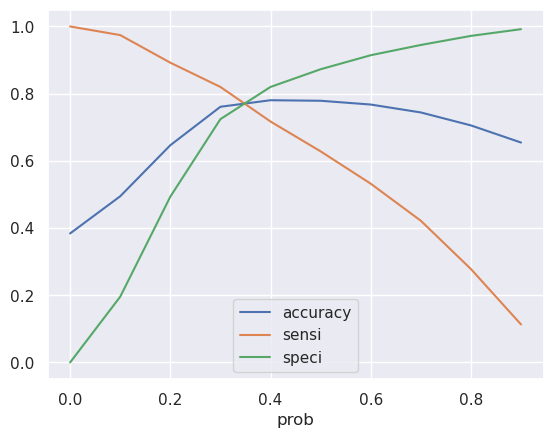

In [1309]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [1310]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.32 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,final_predicted
0,0,0.147,295,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.282,1657,0,1,1,1,0,0,0,0,0,0,0,0
2,1,0.951,4592,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0.153,3558,0,1,1,0,0,0,0,0,0,0,0,0
4,0,0.117,629,0,1,1,0,0,0,0,0,0,0,0,0


In [1311]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.7697510822510822

In [1312]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[3397, 1157],
       [ 545, 2293]])

####  ----------------------------------------------------------------------

#### ROC Curve and Precision - Recall Curve

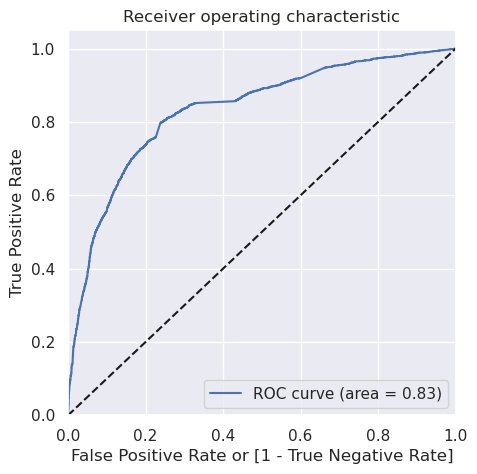

In [1313]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [1314]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.7545493017350825

0.6282593375616632

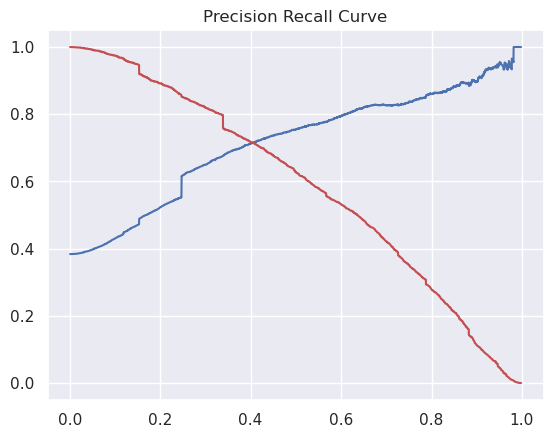

In [1315]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

In [1316]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.39 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,final_predicted
0,0,0.147,295,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.282,1657,0,1,1,1,0,0,0,0,0,0,0,0
2,1,0.951,4592,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0.153,3558,0,1,1,0,0,0,0,0,0,0,0,0
4,0,0.117,629,0,1,1,0,0,0,0,0,0,0,0,0


In [1317]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.7798971861471862

In [1318]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[3707,  847],
       [ 780, 2058]])

###  ----------------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [1319]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [1320]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head()

,lead_origin,lead_source,do_not_email,totalvisits,ttime_on_site,pg_view_pv,last_activity,specialization,curr_occupation,reason_behind_course,city,avail_free_copy
2212,0,-0.399,0,-0.427,1.110,-0.146,0.636,18,-0.126,0,0,0
3034,2,1.905,0,-0.777,1.380,-0.708,-1.276,18,-0.126,0,0,0
4492,0,0.589,0,-0.777,-0.531,-0.708,0.363,18,-0.126,0,0,0
5063,1,0.918,1,0.623,-0.446,0.135,1.182,7,-0.126,0,0,1
7645,0,0.589,0,-1.127,-0.892,-1.269,0.363,18,-0.126,0,0,0


In [1321]:
cutoff = 0.39
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7379
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3595.6
Date:                Sun, 20 Oct 2024   Deviance:                       7191.1
Time:                        17:38:05   Pearson chi2:                 9.18e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3017
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2920      0.097     -3.009      0.003      -0.482      -0.102
lead_origin              0.6374      0.054     11.863      0.000       0.532       0.743
lead_source              0.5349      0.035     15.361      0.000       0.467       0.603
do_not_email            -1.2846      0.136     -9.416      0.000      -1.552      -1.017
totalvisits              0.0947      0.044      2.144      0.032       0.008       0.181
ttime_on_site            1.0508      0.034     30.944      0.000       0.984       1.117
pg_view_pv              -0.4714      0.047    -10.048      0.000      -0.563      -0.379
last_activity            0.5444      0.031     17.708      0.000       0.484       0.605
specialization          -0.0464      0.006     -7.816      0.000      -0.058      -0.035
curr_occupation          0.4263      0.036     11.865      0.000       0.356       0.497
reason_behind_course    -0.3844      1.974     -0.195      0.846      -4.253       3.484
city                     0.0090      0.023      0.386      0.700      -0.037       0.055
avail_free_copy         -0.4398      0.073     -6.057      0.000      -0.582      -0.298
========================================================================================
"""


VIF Score:


,Features,VIF
5,pg_view_pv,2.520
3,totalvisits,2.400
0,lead_origin,2.010
11,avail_free_copy,1.860
7,specialization,1.550
1,lead_source,1.340
10,city,1.310
4,ttime_on_site,1.230
2,do_not_email,1.100
8,curr_occupation,1.040


In [1322]:
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Confusion Matrix:


array([[923, 202],
       [201, 522]])


Accuracy Score: 0.7819264069264069



## Approach - 02 - Accuracy Score:

In [1323]:
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Accuracy Score: 0.7819264069264069



## -----------------------------------------------------

In [1324]:
errorline # do no remove this line

NameError: name 'errorline' is not defined

## -----------------------------------------------------

## Approach - 03

### Data Encoding

#### Dummy Encoding

In [1368]:
#  we perform dummy encoding

new_ls_df = pd.get_dummies(lead_score_df, columns=lead_score_df.select_dtypes('category').columns.difference(['tags','specialization']), drop_first=True, dtype=float)
new_ls_df.head(1)

new_ls_df = pd.get_dummies(new_ls_df, columns=['tags','specialization'], dtype=float)
new_ls_df = new_ls_df.drop(['tags_unknown','specialization_unknown'], axis=1)
new_ls_df.head(1)

,converted,totalvisits,ttime_on_site,pg_view_pv,specialization,tags,avail_free_copy_1,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,curr_occupation_Housewife,curr_occupation_Other,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Working Professional,do_not_email_1,last_activity_Converted to Lead,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Marked Spam,last_activity_Email Opened,last_activity_Email Received,last_activity_Form Submitted on Website,last_activity_Had a Phone Conversation,last_activity_Olark Chat Conversation,last_activity_Page Visited on Website,last_activity_Resubscribed to emails,last_activity_SMS Sent,last_activity_Unreachable,last_activity_Unsubscribed,last_activity_View in browser link Clicked,last_activity_Visited Booth in Tradeshow,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Lead Import,lead_origin_Quick Add Form,lead_source_Direct Traffic,lead_source_Facebook,lead_source_Google,lead_source_Live Chat,lead_source_NC_EDM,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Pay per Click Ads,lead_source_Press_Release,lead_source_Reference,lead_source_Referral Sites,lead_source_Social Media,lead_source_WeLearn,lead_source_Welingak Website,lead_source_bing,lead_source_blog,lead_source_google,lead_source_testone,lead_source_welearnblog_Home,lead_source_youtubechannel,reason_behind_course_Flexibility & Convenience,reason_behind_course_Other
0,0,0.000,0.000,0.000,unknown,Interested in other courses,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


,converted,totalvisits,ttime_on_site,pg_view_pv,avail_free_copy_1,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,curr_occupation_Housewife,curr_occupation_Other,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Working Professional,do_not_email_1,last_activity_Converted to Lead,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Marked Spam,last_activity_Email Opened,last_activity_Email Received,last_activity_Form Submitted on Website,last_activity_Had a Phone Conversation,last_activity_Olark Chat Conversation,last_activity_Page Visited on Website,last_activity_Resubscribed to emails,last_activity_SMS Sent,last_activity_Unreachable,last_activity_Unsubscribed,last_activity_View in browser link Clicked,last_activity_Visited Booth in Tradeshow,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Lead Import,lead_origin_Quick Add Form,lead_source_Direct Traffic,lead_source_Facebook,lead_source_Google,lead_source_Live Chat,lead_source_NC_EDM,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Pay per Click Ads,lead_source_Press_Release,lead_source_Reference,lead_source_Referral Sites,lead_source_Social Media,lead_source_WeLearn,lead_source_Welingak Website,lead_source_bing,lead_source_blog,lead_source_google,lead_source_testone,lead_source_welearnblog_Home,lead_source_youtubechannel,reason_behind_course_Flexibility & Convenience,reason_behind_course_Other,tags_Already a student,tags_Busy,tags_Closed by Horizzon,tags_Diploma holder (Not Eligible),tags_Graduation in progress,tags_In confusion whether part time or DLP,tags_Interested in full time MBA,tags_Interested in Next batch,tags_Interested in other courses,tags_Lateral student,tags_Lost to EINS,tags_Lost to Others,tags_Not doing further education,tags_Recognition issue (DEC approval),tags_Ringing,tags_Shall take in the next coming month,tags_Still Thinking,tags_University not recognized,tags_Want to take admission but has financial problems,tags_Will revert after reading the email,tags_in touch with EINS,tags_invalid number,tags_number not provided,tags_opp hangup,tags_switched off,tags_wrong number given,"specialization_Banking, Investment And Insurance",specialization_Business Administration,specialization_E-Business,specialization_E-COMMERCE,specialization_Finance Management,specialization_Healthcare Management,specialization_Hospitality Management,specialization_Human Resource Management,specialization_IT Projects Management,specialization_International Business,specialization_Marketing Management,specialization_Media and Advertising,specialization_Operations Management,specialization_Retail Management,specialization_Rural and Agribusiness,specialization_Services Excellence,specialization_Supply Chain Management,specialization_Travel and Tourism
0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


###  ----------------------------------------------------------------------

### Train and Test Split

In [1369]:
X = new_ls_df.drop(['converted'], axis=1)
y = new_ls_df['converted']

In [1370]:
# Now we split the dataset into train and test set
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

###  ----------------------------------------------------------------------

### Feature Scaling

In [1371]:
new_ls_df.dtypes

converted                                                   int64
totalvisits                                               float64
ttime_on_site                                             float64
pg_view_pv                                                float64
avail_free_copy_1                                         float64
city_Other Cities                                         float64
city_Other Cities of Maharashtra                          float64
city_Other Metro Cities                                   float64
city_Thane & Outskirts                                    float64
city_Tier II Cities                                       float64
curr_occupation_Housewife                                 float64
curr_occupation_Other                                     float64
curr_occupation_Student                                   float64
curr_occupation_Unemployed                                float64
curr_occupation_Working Professional                      float64
do_not_ema

In [1372]:
# Post split we perform standard scaling they fit and transform the train data set

# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = X.columns
to_scale

scaler = MinMaxScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale], y_train)
X_train.head()

Index(['totalvisits', 'ttime_on_site', 'pg_view_pv', 'avail_free_copy_1',
       'city_Other Cities', 'city_Other Cities of Maharashtra',
       'city_Other Metro Cities', 'city_Thane & Outskirts',
       'city_Tier II Cities', 'curr_occupation_Housewife',
       ...
       'specialization_IT Projects Management',
       'specialization_International Business',
       'specialization_Marketing Management',
       'specialization_Media and Advertising',
       'specialization_Operations Management',
       'specialization_Retail Management',
       'specialization_Rural and Agribusiness',
       'specialization_Services Excellence',
       'specialization_Supply Chain Management',
       'specialization_Travel and Tourism'],
      dtype='object', length=101)

,totalvisits,ttime_on_site,pg_view_pv,avail_free_copy_1,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,curr_occupation_Housewife,curr_occupation_Other,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Working Professional,do_not_email_1,last_activity_Converted to Lead,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Marked Spam,last_activity_Email Opened,last_activity_Email Received,last_activity_Form Submitted on Website,last_activity_Had a Phone Conversation,last_activity_Olark Chat Conversation,last_activity_Page Visited on Website,last_activity_Resubscribed to emails,last_activity_SMS Sent,last_activity_Unreachable,last_activity_Unsubscribed,last_activity_View in browser link Clicked,last_activity_Visited Booth in Tradeshow,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Lead Import,lead_origin_Quick Add Form,lead_source_Direct Traffic,lead_source_Facebook,lead_source_Google,lead_source_Live Chat,lead_source_NC_EDM,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Pay per Click Ads,lead_source_Press_Release,lead_source_Reference,lead_source_Referral Sites,lead_source_Social Media,lead_source_WeLearn,lead_source_Welingak Website,lead_source_bing,lead_source_blog,lead_source_google,lead_source_testone,lead_source_welearnblog_Home,lead_source_youtubechannel,reason_behind_course_Flexibility & Convenience,reason_behind_course_Other,tags_Already a student,tags_Busy,tags_Closed by Horizzon,tags_Diploma holder (Not Eligible),tags_Graduation in progress,tags_In confusion whether part time or DLP,tags_Interested in full time MBA,tags_Interested in Next batch,tags_Interested in other courses,tags_Lateral student,tags_Lost to EINS,tags_Lost to Others,tags_Not doing further education,tags_Recognition issue (DEC approval),tags_Ringing,tags_Shall take in the next coming month,tags_Still Thinking,tags_University not recognized,tags_Want to take admission but has financial problems,tags_Will revert after reading the email,tags_in touch with EINS,tags_invalid number,tags_number not provided,tags_opp hangup,tags_switched off,tags_wrong number given,"specialization_Banking, Investment And Insurance",specialization_Business Administration,specialization_E-Business,specialization_E-COMMERCE,specialization_Finance Management,specialization_Healthcare Management,specialization_Hospitality Management,specialization_Human Resource Management,specialization_IT Projects Management,specialization_International Business,specialization_Marketing Management,specialization_Media and Advertising,specialization_Operations Management,specialization_Retail Management,specialization_Rural and Agribusiness,specialization_Services Excellence,specialization_Supply Chain Management,specialization_Travel and Tourism
295,0.455,0.131,0.417,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1657,0.091,0.095,0.167,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.

###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [1373]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model 1

In [1374]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm1.fit()
# res.summary()

##### RFE - Recursive Feature Elimination

In [1375]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features
logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('totalvisits', False, 11),
 ('ttime_on_site', True, 1),
 ('pg_view_pv', False, 10),
 ('avail_free_copy_1', False, 61),
 ('city_Other Cities', False, 69),
 ('city_Other Cities of Maharashtra', False, 86),
 ('city_Other Metro Cities', False, 82),
 ('city_Thane & Outskirts', False, 64),
 ('city_Tier II Cities', False, 68),
 ('curr_occupation_Housewife', False, 50),
 ('curr_occupation_Other', False, 52),
 ('curr_occupation_Student', False, 74),
 ('curr_occupation_Unemployed', False, 21),
 ('curr_occupation_Working Professional', False, 35),
 ('do_not_email_1', False, 7),
 ('last_activity_Converted to Lead', False, 6),
 ('last_activity_Email Bounced', False, 39),
 ('last_activity_Email Link Clicked', False, 55),
 ('last_activity_Email Marked Spam', False, 62),
 ('last_activity_Email Opened', False, 19),
 ('last_activity_Email Received', False, 78),
 ('last_activity_Form Submitted on Website', False, 51),
 ('last_activity_Had a Phone Conversation', False, 8),
 ('last_activity_Olark Chat Co

In [1376]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index(['totalvisits', 'pg_view_pv', 'avail_free_copy_1', 'city_Other Cities',
       'city_Other Cities of Maharashtra', 'city_Other Metro Cities',
       'city_Thane & Outskirts', 'city_Tier II Cities',
       'curr_occupation_Housewife', 'curr_occupation_Other',
       'curr_occupation_Student', 'curr_occupation_Unemployed',
       'curr_occupation_Working Professional', 'do_not_email_1',
       'last_activity_Converted to Lead', 'last_activity_Email Bounced',
       'last_activity_Email Link Clicked', 'last_activity_Email Marked Spam',
       'last_activity_Email Opened', 'last_activity_Email Received',
       'last_activity_Form Submitted on Website',
       'last_activity_Had a Phone Conversation',
       'last_activity_Olark Chat Conversation',
       'last_activity_Page Visited on Website',
       'last_activity_Resubscribed to emails', 'last_activity_Unreachable',
       'last_activity_Unsubscribed',
       'last_activity_View in browser link Clicked',
       'last_activity_Vis

##### Model 1

In [1377]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7376
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1662.6
Date:                Sun, 20 Oct 2024   Deviance:                       3325.1
Time:                        17:38:53   Pearson chi2:                 8.01e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.5861
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.6163      0.080    -32.533      0.000      -2.774      -2.459
ttime_on_site                                3.3315      0.187     17.783      0.000       2.964       3.699
last_activity_SMS Sent                       1.9934      0.096     20.678      0.000       1.804       2.182
lead_source_Welingak Website                 5.3886      0.727      7.413      0.000       3.964       6.813
tags_Already a student                      -3.5340      0.714     -4.951      0.000      -4.933      -2.135
tags_Closed by Horizzon                      6.7310      0.715      9.415      0.000       5.330       8.132
tags_Interested  in full time MBA           -2.4360      0.749     -3.253      0.001      -3.904      -0.968
tags_Interested in other courses            -1.9668      0.313     -6.289      0.000      -2.580      -1.354
tags_Lost to EINS                            5.0718      0.518      9.798      0.000       4.057       6.086
tags_Not doing further education            -3.3423      1.013     -3.300      0.001      -5.328      -1.357
tags_Ringing                                -2.8643      0.207    -13.819      0.000      -3.271      -2.458
tags_Will revert after reading the email     4.5023      0.150     29.964      0.000       4.208       4.797
tags_invalid number                         -3.4765      1.065     -3.264      0.001      -5.564      -1.389
tags_number not provided                   -24.0707   2.43e+04     -0.001      0.999   -4.77e+04    4.76e+04
tags_switched off                           -3.3473      0.520     -6.434      0.000      -4.367      -2.328
tags_wrong number given                    -23.8164   1.93e+04     -0.001      0.999   -3.79e+04    3.79e+04
============================================================================================================
"""


VIF Score:


,Features,VIF
0,ttime_on_site,1.680
10,tags_Will revert after reading the email,1.550
1,last_activity_SMS Sent,1.480
9,tags_Ringing,1.110
4,tags_Closed by Horizzon,1.060
7,tags_Lost to EINS,1.040
2,lead_source_Welingak Website,1.030
13,tags_switched off,1.030
3,tags_Already a student,1.020
6,tags_Interested in other courses,1.020


##### Model 2

In [1378]:
col = col.drop('tags_number not provided', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['ttime_on_site', 'last_activity_SMS Sent',
       'lead_source_Welingak Website', 'tags_Already a student',
       'tags_Closed by Horizzon', 'tags_Interested  in full time MBA',
       'tags_Interested in other courses', 'tags_Lost to EINS',
       'tags_Not doing further education', 'tags_Ringing',
       'tags_Will revert after reading the email', 'tags_invalid number',
       'tags_switched off', 'tags_wrong number given'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7377
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1672.0
Date:                Sun, 20 Oct 2024   Deviance:                       3344.1
Time:                        17:38:53   Pearson chi2:                 7.98e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.5850
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.6211      0.080    -32.641      0.000      -2.778      -2.464
ttime_on_site                                3.3003      0.186     17.707      0.000       2.935       3.666
last_activity_SMS Sent                       1.9823      0.096     20.648      0.000       1.794       2.170
lead_source_Welingak Website                 5.3965      0.727      7.424      0.000       3.972       6.821
tags_Already a student                      -3.5178      0.714     -4.929      0.000      -4.917      -2.119
tags_Closed by Horizzon                      6.7395      0.715      9.428      0.000       5.338       8.141
tags_Interested  in full time MBA           -2.4170      0.748     -3.231      0.001      -3.883      -0.951
tags_Interested in other courses            -1.9485      0.312     -6.238      0.000      -2.561      -1.336
tags_Lost to EINS                            5.0827      0.518      9.821      0.000       4.068       6.097
tags_Not doing further education            -3.3241      1.013     -3.282      0.001      -5.309      -1.339
tags_Ringing                                -2.8397      0.207    -13.725      0.000      -3.245      -2.434
tags_Will revert after reading the email     4.5141      0.150     30.064      0.000       4.220       4.808
tags_invalid number                         -3.4515      1.063     -3.246      0.001      -5.536      -1.367
tags_switched off                           -3.3234      0.520     -6.392      0.000      -4.342      -2.304
tags_wrong number given                    -22.7936   1.17e+04     -0.002      0.998    -2.3e+04     2.3e+04
============================================================================================================
"""


VIF Score:


,Features,VIF
0,ttime_on_site,1.680
10,tags_Will revert after reading the email,1.550
1,last_activity_SMS Sent,1.480
9,tags_Ringing,1.110
4,tags_Closed by Horizzon,1.060
7,tags_Lost to EINS,1.040
2,lead_source_Welingak Website,1.030
12,tags_switched off,1.030
3,tags_Already a student,1.020
6,tags_Interested in other courses,1.020


##### Model 3

In [1379]:
col = col.drop('tags_wrong number given', 1)
col

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

Index(['ttime_on_site', 'last_activity_SMS Sent',
       'lead_source_Welingak Website', 'tags_Already a student',
       'tags_Closed by Horizzon', 'tags_Interested  in full time MBA',
       'tags_Interested in other courses', 'tags_Lost to EINS',
       'tags_Not doing further education', 'tags_Ringing',
       'tags_Will revert after reading the email', 'tags_invalid number',
       'tags_switched off'],
      dtype='object')

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7378
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1685.3
Date:                Sun, 20 Oct 2024   Deviance:                       3370.5
Time:                        17:38:54   Pearson chi2:                 7.94e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5835
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.6332      0.080    -32.844      0.000      -2.790      -2.476
ttime_on_site                                3.2969      0.186     17.757      0.000       2.933       3.661
last_activity_SMS Sent                       1.9540      0.095     20.490      0.000       1.767       2.141
lead_source_Welingak Website                 5.4150      0.727      7.452      0.000       3.991       6.839
tags_Already a student                      -3.5004      0.714     -4.905      0.000      -4.899      -2.102
tags_Closed by Horizzon                      6.7526      0.715      9.446      0.000       5.352       8.154
tags_Interested  in full time MBA           -2.3946      0.747     -3.205      0.001      -3.859      -0.930
tags_Interested in other courses            -1.9275      0.312     -6.178      0.000      -2.539      -1.316
tags_Lost to EINS                            5.0964      0.517      9.848      0.000       4.082       6.111
tags_Not doing further education            -3.3026      1.013     -3.262      0.001      -5.287      -1.318
tags_Ringing                                -2.8049      0.207    -13.583      0.000      -3.210      -2.400
tags_Will revert after reading the email     4.5314      0.150     30.205      0.000       4.237       4.825
tags_invalid number                         -3.4164      1.062     -3.215      0.001      -5.499      -1.334
tags_switched off                           -3.2871      0.520     -6.325      0.000      -4.306      -2.269
============================================================================================================
"""


VIF Score:


,Features,VIF
0,ttime_on_site,1.680
10,tags_Will revert after reading the email,1.540
1,last_activity_SMS Sent,1.480
9,tags_Ringing,1.110
4,tags_Closed by Horizzon,1.060
7,tags_Lost to EINS,1.040
2,lead_source_Welingak Website,1.030
12,tags_switched off,1.030
3,tags_Already a student,1.020
6,tags_Interested in other courses,1.020



Confusion Matrix:


array([[4381,  173],
       [ 474, 2364]])


Accuracy Score: 0.9124729437229437



##### Model 4

In [1380]:
# col = col.drop('country_Qatar', 1)
# col


# cutoff = 0.5
# res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
# confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
# vif = logreg_VIF_score_fn(X_train, col)

# print('Model Summary:')          # Model Summary:
# res.summary()
# print('\nVIF Score:')            # VIF Score:
# vif

# # print('\nY_Predicted Values:')   # Y_Predicted Values:
# # y_train_pred
# # print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# # y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

##### Model 5

In [1381]:
# col = col.drop('last_activity_Email Marked Spam', 1)
# col

# cutoff = 0.5
# res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
# confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
# vif = logreg_VIF_score_fn(X_train, col)

# print('Model Summary:')          # Model Summary:
# res.summary()
# print('\nVIF Score:')            # VIF Score:
# vif

# # print('\nY_Predicted Values:')   # Y_Predicted Values:
# # y_train_pred
# # print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# # y_train_pred_final
# print('\nConfusion Matrix:')     # Confusion Matrix: 
# confusion
# print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

####  ----------------------------------------------------------------------

#### Finding Optimal Cutoff Point

In [1382]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900
0,0,0.100,295,0,1,0,0,0,0,0,0,0,0,0
1,0,0.089,1657,0,1,0,0,0,0,0,0,0,0,0
2,1,0.999,4592,1,1,1,1,1,1,1,1,1,1,1
3,0,0.067,3558,0,1,0,0,0,0,0,0,0,0,0
4,0,0.104,629,0,1,1,0,0,0,0,0,0,0,0


In [1383]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.384  1.000  0.000
0.100 0.100     0.837  0.954  0.765
0.200 0.200     0.890  0.937  0.861
0.300 0.300     0.896  0.915  0.884
0.400 0.400     0.904  0.853  0.935
0.500 0.500     0.912  0.833  0.962
0.600 0.600     0.912  0.820  0.968
0.700 0.700     0.907  0.799  0.973
0.800 0.800     0.898  0.763  0.982
0.900 0.900     0.868  0.672  0.989


<Axes: xlabel='prob'>

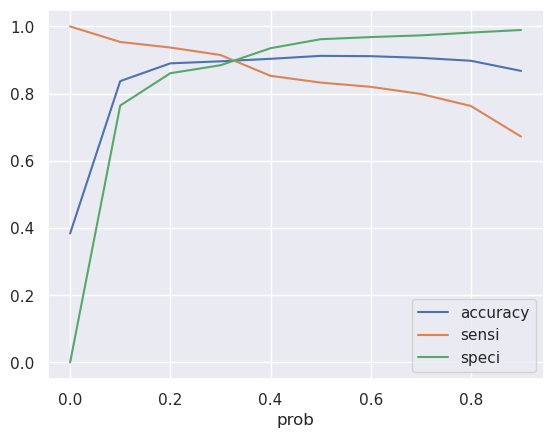

In [1384]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [1385]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.32 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,final_predicted
0,0,0.100,295,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.089,1657,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0.999,4592,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0.067,3558,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.104,629,0,1,1,0,0,0,0,0,0,0,0,0


In [1386]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8979978354978355

In [1387]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[4053,  501],
       [ 253, 2585]])

#### ROC Curve and Precision - Recall Curve

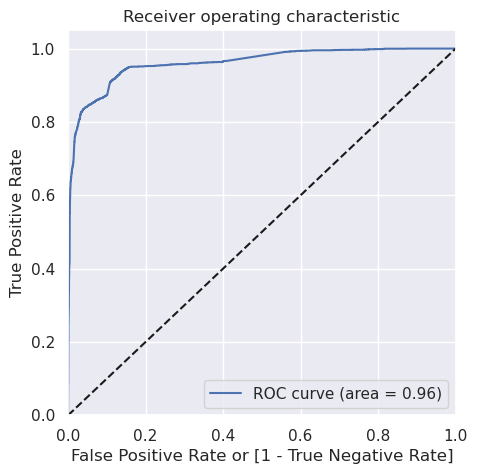

In [1388]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [1389]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.9318092234923138

0.8329809725158562

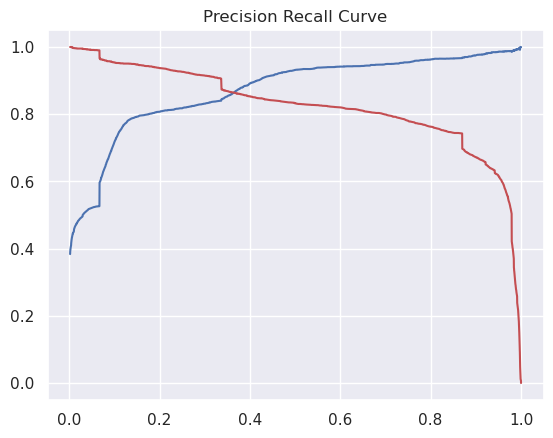

In [1390]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

In [1391]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.37 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,ID,predicted,0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,final_predicted
0,0,0.100,295,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.089,1657,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0.999,4592,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0.067,3558,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.104,629,0,1,1,0,0,0,0,0,0,0,0,0


In [1392]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8977272727272727

In [1393]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

array([[4189,  365],
       [ 391, 2447]])

###  ----------------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [1394]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in 
                   range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [1395]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head()

,ttime_on_site,last_activity_SMS Sent,lead_source_Welingak Website,tags_Already a student,tags_Closed by Horizzon,tags_Interested in full time MBA,tags_Interested in other courses,tags_Lost to EINS,tags_Not doing further education,tags_Ringing,tags_Will revert after reading the email,tags_invalid number,tags_switched off
2212,0.484,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
3034,0.549,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
4492,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5063,0.108,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
7645,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [1396]:
cutoff = 0.37
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7378
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1685.3
Date:                Sun, 20 Oct 2024   Deviance:                       3370.5
Time:                        17:38:55   Pearson chi2:                 7.94e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5835
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.6332      0.080    -32.844      0.000      -2.790      -2.476
ttime_on_site                                3.2969      0.186     17.757      0.000       2.933       3.661
last_activity_SMS Sent                       1.9540      0.095     20.490      0.000       1.767       2.141
lead_source_Welingak Website                 5.4150      0.727      7.452      0.000       3.991       6.839
tags_Already a student                      -3.5004      0.714     -4.905      0.000      -4.899      -2.102
tags_Closed by Horizzon                      6.7526      0.715      9.446      0.000       5.352       8.154
tags_Interested  in full time MBA           -2.3946      0.747     -3.205      0.001      -3.859      -0.930
tags_Interested in other courses            -1.9275      0.312     -6.178      0.000      -2.539      -1.316
tags_Lost to EINS                            5.0964      0.517      9.848      0.000       4.082       6.111
tags_Not doing further education            -3.3026      1.013     -3.262      0.001      -5.287      -1.318
tags_Ringing                                -2.8049      0.207    -13.583      0.000      -3.210      -2.400
tags_Will revert after reading the email     4.5314      0.150     30.205      0.000       4.237       4.825
tags_invalid number                         -3.4164      1.062     -3.215      0.001      -5.499      -1.334
tags_switched off                           -3.2871      0.520     -6.325      0.000      -4.306      -2.269
============================================================================================================
"""


VIF Score:


,Features,VIF
0,ttime_on_site,1.640
10,tags_Will revert after reading the email,1.520
1,last_activity_SMS Sent,1.470
9,tags_Ringing,1.150
4,tags_Closed by Horizzon,1.080
2,lead_source_Welingak Website,1.040
6,tags_Interested in other courses,1.030
7,tags_Lost to EINS,1.030
12,tags_switched off,1.030
3,tags_Already a student,1.010


In [1397]:
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Confusion Matrix:


array([[1050,   75],
       [ 100,  623]])


Accuracy Score: 0.9053030303030303



## Approach - 03 - Accuracy Score:

In [1398]:
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


Accuracy Score: 0.9053030303030303



## ------------------------------------------------------